# Transductive Transfer Learning
In this notebook, the model architecture and weights saved from the inductive approach will be used. A new variant of the original MATLAB dataset, used for the inductive model, was generated with the following changes:

The updated dataset retains the core structure of the baseline dataset used for training the inductive transfer learning model. However, it introduces new elements, including narrowband and broadband interferences, as well as Rayleigh or Rician fading. Unlike the baseline dataset, which only contained AWGN (Additive White Gaussian Noise) as interference, this updated version incorporates these additional challenges to better simulate real-world signal conditions.

The SNR and Doppler shift ranges have also been updated to accommodate a broader range. The updates are as follows:

SNR Range

- 0 to 40 (Baseline dataset)
- -10 to 50 (Updated dataset)

Doppler Shift Range

- 0 to 500 (Baseline dataset)
- 0 to 2000 (Updated dataset)

The inductive model will be initially tested without any further training or tuning to assess its performance on the variant dataset. Afterward, the ResNet-101 feature extractor, which was trained on the inductive model's baseline dataset, will be frozen, while the DeepLabv3+ encoder will be unfrozen. This will allow training of only the segmentation task, not the feature extraction task. Subsequently, similar analyses performed for the inductive model, such as performance evaluation, interpretability, and classification, will be conducted.

Note that gradual unfreezing or full unfreezing of the ResNet-101 encoder will not be done, as it would be impractical to retrain an inductive model, thus defeating the purpose of this transductive approach. Additionally, this approach would require more steps, training, and resources compared to the inductive approach.

In [1]:
import os
import requests
import zipfile
import tarfile
import h5py
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar
from PIL import Image
from itertools import zip_longest
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
from torchvision import models, transforms
from torchvision.transforms.functional import resize, to_pil_image
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchinfo import summary
import pandas as pd
import seaborn as sns
import pprint
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from matplotlib.lines import Line2D
from matplotlib import colors
import optuna
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from segmentation_models_pytorch.losses import LovaszLoss, DiceLoss, JaccardLoss
from torch.cuda.amp import autocast, GradScaler
import re
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix


## Functions

### load_images_from_dirs Function
This function is used to load image files from specified directories. It:

- Iterates through all directories and subdirectories.
- Looks for .png files.
- Opens and converts them into numpy arrays using PIL.
- Appends each image to a list and returns the list of images.

In [2]:
def load_images_from_dirs(directories):
    images = []
    for directory in directories:
        image_files = [f for f in os.listdir(directory) if f.endswith('.png')]
        for file_name in image_files:
            file_path = os.path.join(directory, file_name)  # Create the full file path
            img = Image.open(file_path)  # Open the image file
            img = np.array(img)  # Convert PIL image to numpy array
            images.append(img)  # Add the image to the list

    return images

#This function, load_images_from_dirs, takes a list of directory paths as input. 
#It searches for .png image files in each directory, opens them, converts them to numpy arrays, and stores them in a list. 
#The function returns the list of images after processing all the directories.

### PixelLabelDatastore Class
This class handles loading and processing pixel label data stored in .h5 files:

- Initialization: Takes a list of directories and class names to map pixel values to indices.
- load_pixel_labels_from_dirs: Loads the pixel labels from .h5 files, maps raw pixel values to sequential class indices, and then maps those indices to class names.
- map_pixel_values_to_indices: A helper method that maps raw pixel values to class indices.
- map_indices_to_class_names: Maps numeric labels to class names.
- get_original_labels and get_mapped_labels: These methods return the original numeric labels and the class names after mapping.

In [3]:
class PixelLabelDatastore:
    def __init__(self, directories, class_names):
        self.class_names = class_names
        self.pixel_label_ids = np.arange(len(class_names))  # Sequential IDs: 0, 1, 2, ...
        self.pixel_labels = self.load_pixel_labels_from_dirs(directories)

    def load_pixel_labels_from_dirs(self, directories):
        pixel_labels = []
        for directory in directories:
            if not os.path.exists(directory):
                print(f"Directory does not exist: {directory}")
                continue

            hfive_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
            for file_name in hfive_files:
                file_path = os.path.join(directory, file_name)
                if not os.path.exists(file_path):
                    print(f"File does not exist: {file_path}")
                    continue

                try:
                    with h5py.File(file_path, 'r') as hfive_file:
                        if 'labels' in hfive_file:
                            label_data = hfive_file['labels'][:]
                            # Map pixel values to numeric indices
                            numeric_labels = self.map_pixel_values_to_indices(label_data)
                            pixel_labels.append({'original': numeric_labels})  # Store only numeric labels
                            
                        else:
                            print(f"'labels' dataset not found in {file_path}")
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")

        return pixel_labels

    def map_pixel_values_to_indices(self, label_data):
        # Map raw pixel values to sequential class indices (0, 1, 2, ...)
        raw_to_sequential = {raw: idx for idx, raw in enumerate(
            np.floor(np.arange(len(self.class_names)) / (len(self.class_names) - 1) * 255).astype(int)
        )}
        # Assign the "Unknown" class index (e.g., 3) to any value not in raw_to_sequential
        return np.vectorize(lambda x: raw_to_sequential.get(x, len(self.class_names) - 1))(label_data)


    def get_original_labels(self):
        # Collect and return all original numeric labels
        return [sample['original'] for sample in self.pixel_labels]

    def get_mapped_labels(self):
        # Collect and return all mapped class name labels
        return [sample['mapped'] for sample in self.pixel_labels]


#This class, PixelLabelDatastore, is designed to handle pixel-level labeled data for image segmentation. 
#It takes a list of directories and class names as input. The class loads pixel label data from .h5 files in the specified directories and 
#maps raw pixel values to class indices and class names.

#The load_pixel_labels_from_dirs method loads and processes label data from .h5 files in each directory.
# It processes by reading each H5 file, extracting the labels and mapping them to raw pixel value (0,1,2). 
#The map_pixel_values_to_indices method maps raw pixel values to sequential class indices.
#The map_indices_to_class_names method maps class indices to class names.
#The get_original_labels method retrieves the original numeric labels.
#The get_mapped_labels method retrieves the mapped class name labels.
        
#This class helps in organizing and mapping pixel-level labeled data for image segmentation tasks.

### process_params_and_filter_bw_mod Function
This function processes metadata from .mat files:

- Bandwidth and Modulation Mapping: It uses mappings for modulation types and bandwidth values to convert these into indices.
- Processing .mat Files: It loads .mat files, processes their parameters, and removes unnecessary fields (like Info). It then filters the data to include only bandwidth, modulation, SNR, and Doppler values.
- Handling Modulation and Bandwidth: The function checks for these values, maps them to their respective indices, and adds them to the dictionary of processed metadata.

In [4]:
def process_params_and_filter_bw_mod(directories):
    processed_data = []

    rc_to_bw = {'R.2': 10, 'R.6': 5, 'R.7': 10, 'R.8': 15, 'R.9': 20}
    modulation_types = ["QPSK", "16QAM", "64QAM", "256QAM"]
    mod_type_to_index = {mod: idx for idx, mod in enumerate(modulation_types)}
    bandwidth_values = [5, 10, 15, 20, 25, 30, 40, 50]
    bw_to_index = {bw: idx for idx, bw in enumerate(bandwidth_values)}
    class_map = {'NR': 1, 'LTE': 0, 'LTE_NR': 2}  # Updated class map

    for directory in directories:
        if not os.path.exists(directory):
            print(f"Directory does not exist: {directory}")
            continue

        mat_files = [f for f in os.listdir(directory) if f.endswith('.mat')]

        for file_name in mat_files:
            file_path = os.path.join(directory, file_name)
            if not os.path.exists(file_path):
                print(f"File does not exist: {file_path}")
                continue

            try:
                match = re.search(r'(LTE_NR|NR|LTE)', file_name)
                class_label = match.group(1) if match else None
                class_index = class_map.get(class_label, None)
                
                mat_data = loadmat(file_path)
                params = mat_data.get('params', None)
                if params is None:
                    print(f"Skipping file (no 'params' data): {file_path}")
                    continue

                params_without_info = {}
                for field in params[0, 0].dtype.names:
                    if field != 'Info':
                        field_data = params[0, 0][field]
                        if field_data.shape == (1, 1) or (isinstance(field_data, np.ndarray) and field_data.shape == (1,)):
                            field_data = field_data.item()
                        if field == 'RC' and field_data in rc_to_bw:
                            field_data = rc_to_bw[field_data]
                            field = 'BW'
                        params_without_info[field] = field_data

                processed_data.append({
                    'file_name': file_name,
                    'img_class_label': class_index,
                    'params_without_info': params_without_info
                })

                filtered_fields = ['BW', 'Modulation', 'SNRdB', 'Doppler']
                filtered_data = {field: params_without_info.get(field) for field in filtered_fields}
                filtered_data['Modulation_Index'] = mod_type_to_index.get(filtered_data.get('Modulation'))
                filtered_data['BW_Index'] = bw_to_index.get(filtered_data.get('BW'))
                filtered_data['img_class_label'] = class_index

                processed_data[-1]['filtered'] = filtered_data
            
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    return processed_data


### helper_spec_sense_partition_data Function
This function partitions the datasets into training, validation, and test sets:

- Input Validation: It ensures the input percentages sum to 100%.
- Shuffling: It randomly shuffles the dataset to ensure no bias in the splits.
- Data Partitioning: The data is partitioned based on the specified percentages (e.g., 80% training and 20% test).
- Returning Partitions: The function returns the partitioned datasets.

In [5]:
def helper_spec_sense_partition_data(imds, pxds, processed_metadata, parts):
    """
    Partitions the image and pixel label datasets into training and test subsets.
    Also returns the respective BW, Modulation types, SNR, Doppler values, and file names for each partition.

    Parameters:
        imds (list): List of images (numpy arrays).
        pxds (list): List of pixel label datasets (numpy arrays).
        processed_metadata (list): List of filtered metadata dictionaries containing 'BW', 'SNR', 'Doppler', and 'file_name'.
        parts (list): A 1x2 list of percentages [train, test].
                     The sum of the elements must equal 100.

    Returns:
        tuple:
        - images_train, labels_train: Training data subsets.
        - BW_train, SNR_train, Doppler_train, file_names_train: Training metadata.
        - images_test, labels_test: Test data subsets.
        - BW_test, SNR_test, Doppler_test, file_names_test: Test metadata.
    """

     
    
    # Validate input
    if len(parts) != 2 or sum(parts) != 100:
        raise ValueError("Parts must be a list of two elements summing to 100.")

    # Set random seed for reproducibility
    np.random.seed(0)

    # Shuffle indices
    num_files = len(imds)
    shuffled_indices = np.random.permutation(num_files)

    # Compute split indices
    num_train = int(num_files * parts[0] / 100)

    # Split indices
    train_indices = shuffled_indices[:num_train]
    test_indices = shuffled_indices[num_train:]

    # Subset data
    def get_partition(indices):
        images = [imds[i] for i in indices]
        labels = [pxds[i] for i in indices]
        metadata_subset = [processed_metadata[i]['filtered'] for i in indices]
        file_names = [processed_metadata[i]['file_name'] for i in indices]
        return images, labels, file_names
    
    

    # Get train and test partitions
    images_train, labels_train, file_names_train = get_partition(train_indices)
    images_test, labels_test, file_names_test = get_partition(test_indices)
    
    
    # Stack all original labels and images into single NumPy arrays for efficient tensor creation
    labels_train = np.stack([sample['original'] for sample in labels_train], axis=0)
    images_train = np.stack(images_train, axis=0)

    labels_test = np.stack([sample['original'] for sample in labels_test], axis=0)
    images_test = np.stack(images_test, axis=0)

    # Return data and metadata
    return (images_train, labels_train, file_names_train,
        images_test, labels_test, file_names_test)
#This function splits image, label data and signal attributes into training and test sets based on the percentages provided.

In [6]:
def combine(imds, pxds, file_names):
    """Combine image, pixel label, BW, modulation, SNR, Doppler, and file name datasets."""
    return list(zip(imds, pxds, file_names))

### ImageLabelDataset Class
This is a custom dataset class derived from torch.utils.data.Dataset. It is used for PyTorch training:

Initialization: Takes in images, labels, bandwidths, modulation types, SNR, and Doppler values as inputs.
__len__: Returns the size of the dataset (i.e., the number of samples).

In [7]:
class ImageLabelDataset(Dataset):
    def __init__(self, images, labels, file_names):
        """
        Initializes the dataset.
        Args:
            images (torch.Tensor): Tensor of images.
            labels (torch.Tensor): Tensor of pixel-wise segmentation labels.
            file_names (list): List of file names corresponding to images.
        """
        self.images = images
        self.labels = labels
        self.file_names = file_names
        

    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.images)
    

    def __getitem__(self, idx):
        """
        Fetches a single data point.
        Args:
            idx (int): Index of the data point.
        Returns:
            tuple: A tuple containing the image, segmentation label, bandwidth label, modulation type label, file name and image label.
        """
        image = self.images[idx]
        label = self.labels[idx]
        file_name = self.file_names[idx]
        return image, label,file_name

#This class, ImageLabelDataset, is used to store images and their labels for PyTorch.

#The __init__ method saves the images and labels when the dataset is created.
#The __len__ method returns the number of images in the dataset.
#The __getitem__ method gets an image and its label using an index.
        
#It helps in loading and using image-label pairs for training machine learning models in PyTorch.

## Training Data Directory and Class Setup
The updated dataset retains the core structure of the baseline dataset used for training the inductive transfer learning model. However, it introduces new elements, including narrowband and broadband interferences, as well as Rayleigh or Rician fading. Unlike the baseline dataset, which only contained AWGN (Additive White Gaussian Noise) as interference, this updated version incorporates these additional challenges to better simulate real-world signal conditions.

The SNR and Doppler shift ranges has also been updated to accomodate a bigger range. The updates are as such:

SNR Range
- 0 to 40 (Baseline dataset)
- -10 to 50 (Updated dataset)
  
Doppler Shift Range
- 0 to 500 (Baseline dataset)
- 0 to 2000 (Updated dataset)

In [8]:
comb_data_dir = [r'C:\Users\mathu\OneDrive\Desktop\EEE Y4.S1\FYP\MATLAB data generation finalised\UnkownScenariosData\128x128\LTE_NR']
class_names = ["Noise", "NR", "LTE" , "Unknown"]  # Define class names
num_classes = len(class_names)
pixel_label_ids = np.floor(np.arange(num_classes) / (num_classes - 1) * 255).astype(int)

## Image datastore
A function that loads all .png images in each specified directory.
For each image, it:
- Collects file names ending in .png.
- Opens the image, converts it to a NumPy array, and appends it to images.
- This function will return a list of images (in NumPy array form) stored in training_images.


In [9]:
combined_images = load_images_from_dirs(comb_data_dir)
print(f"Loaded {len(combined_images)} images.")

Loaded 1000 images.


In [10]:
# Load pixel labels using the updated PixelLabelDatastore class
pxds_truth_combined = PixelLabelDatastore(comb_data_dir, class_names)


# Print the number of datasets loaded (it will now reflect the number of samples)
print(f"Loaded {len(pxds_truth_combined.pixel_labels)} sets of pixel labels.")

Loaded 1000 sets of pixel labels.


In [11]:
processed_metadata_combined = process_params_and_filter_bw_mod(comb_data_dir)

# Print the number of datasets loaded (it will now reflect the number of samples)
print(f"Processed {len(processed_metadata_combined)} number of metadata files.")

Processed 1000 number of metadata files.


In [12]:
processed_metadata_combined = sorted(processed_metadata_combined, key=lambda x: x['file_name'])

Viewing a sample of the dictionary created

In [13]:
processed_metadata_combined[5]

{'file_name': 'LTE_NR_frame_1001.mat',
 'img_class_label': 2,
 'params_without_info': {'SCS': 15,
  'BW': 5,
  'SNRdB': 13.685840085846195,
  'Doppler': 983.9451065747372,
  'TrBlkOff': 1},
 'filtered': {'BW': 5,
  'Modulation': None,
  'SNRdB': 13.685840085846195,
  'Doppler': 983.9451065747372,
  'Modulation_Index': None,
  'BW_Index': 0,
  'img_class_label': 2}}

## Train test datasplit

In [14]:
# Partition data
parts = [80,20]
(images_train_comb, labels_train_comb, file_names_train_comb,
images_test_comb, labels_test_comb,  file_names_test_comb) =helper_spec_sense_partition_data(combined_images, pxds_truth_combined.pixel_labels, processed_metadata_combined, parts)

In [15]:
cds_train = combine(images_train_comb, labels_train_comb, file_names_train_comb)
cds_test = combine(images_test_comb, labels_test_comb, file_names_test_comb)

print(f"Training set: {len(cds_train)} pairs")
print(f"Test set: {len(cds_test)} pairs")


Training set: 800 pairs
Test set: 200 pairs


## PyTorch tensors conversion
This code prepares the data for training in PyTorch, normalizes the images, Permute Tensor Dimensions, and prints the tensor shapes for verification. 

In [16]:
# Now you can convert the stacked arrays to tensors
images_train_tensor = torch.tensor(images_train_comb, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train_comb, dtype=torch.long)

images_test_tensor = torch.tensor(images_test_comb, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test_comb, dtype=torch.long)


# Normalize images (after converting to tensors)
images_train_tensor = images_train_tensor / 255.0
images_train_tensor = images_train_tensor.permute(0, 3, 1, 2)  # Convert to (N, C, H, W)

images_test_tensor = images_test_tensor / 255.0
images_test_tensor = images_test_tensor.permute(0, 3, 1, 2)

# Example of tensor shapes
print(f"Training images tensor shape: {images_train_tensor.shape}")
print(f"Training labels tensor shape: {labels_train_tensor.shape}")

print("-"*60)

print(f"Testing images tensor shape: {images_test_tensor.shape}")
print(f"Testing labels tensor shape: {labels_test_tensor.shape}")


Training images tensor shape: torch.Size([800, 3, 128, 128])
Training labels tensor shape: torch.Size([800, 128, 128])
------------------------------------------------------------
Testing images tensor shape: torch.Size([200, 3, 128, 128])
Testing labels tensor shape: torch.Size([200, 128, 128])


## Data Loading

In [17]:
# Create datasets
train_dataset = ImageLabelDataset(images=images_train_tensor, labels=labels_train_tensor, 
                                   file_names=file_names_train_comb)

test_dataset = ImageLabelDataset(images=images_test_tensor, labels=labels_test_tensor, 
                                 file_names=file_names_test_comb )

# Create DataLoaders
batch_size = 16  # You can adjust the batch size based on your available memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



## Alignement verification

In [18]:
# Verifying the alignment between the dataset and metadata (e.g., file names)
for idx in range(len(train_dataset)):
    _, _, file_name = train_dataset[idx]
    assert file_name == file_names_train_comb[idx], f"Mismatch at index {idx}"
print("Train dataset and metadata are aligned!")

for idx in range(len(test_dataset)):
    _, _, file_name= test_dataset[idx]
    assert file_name == file_names_test_comb[idx], f"Mismatch at index {idx}"
print("Test dataset and metadata are aligned!")


Train dataset and metadata are aligned!
Test dataset and metadata are aligned!


## DeepLab v3+

As we are incorporating a transductive transfer learning approach by using the saved model architecture and weights from the inductive transfer learning approach, there is no need to recreate the model architecture or weights. It will be loaded from the saved parameters as shown below.

In [19]:
model_weights_path = r"C:\Users\mathu\OneDrive\Desktop\Final Year Project - Spectrum Sensing\FYP-spectrum-sensing\Python files\deeplab_model_full.pth"
# Load the entire model (architecture + weights)
deeplab_model = torch.load(model_weights_path)  # Load the entire model
#deeplab_model.to(device)  # Ensure the model is moved to the correct device (GPU/CPU)

C:\Users\mathu\AppData\Local\Temp\ipykernel_5832\784131567.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeplab_model = torch.load(model_weights_path)  # Load the ent

The same evaluation function will be used from the inductive transfer learning-based model

In [20]:
def calculate_per_image_pixel_accuracy(predictions, labels):
    """
    Calculate the pixel-wise accuracy for each image in the batch.
    """
    predictions_flat = predictions.flatten()
    labels_flat = labels.flatten()

    correct_pixels = (predictions_flat == labels_flat).sum()
    total_pixels = labels_flat.shape[0]

    accuracy = correct_pixels / total_pixels
    return accuracy

# Loss functions (ensure you have them defined or imported)
lovasz_loss = LovaszLoss(mode='multiclass')
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(mode='multiclass')
jaccard_loss = JaccardLoss(mode='multiclass')

def combined_loss(preds, targets):
    return jaccard_loss(preds, targets) + ce_loss(preds, targets)

def evaluate_model_with_loaded_model(test_loader, device, num_classes, deeplab_model):
    """
    Evaluate the model on a new dataset after loading the saved weights.
    """
    deeplab_model.to(device)  # Ensure the model is moved to the correct device (GPU/CPU)
    
    deeplab_model.eval()  # Set the model to evaluation mode
    
    criterion_segmentation = combined_loss  # For segmentation

    running_segmentation_loss = 0.0
    all_segmentation_preds = []
    all_segmentation_labels = []
    per_image_accuracy_dict = {}

    images_list = []

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Validation', unit='batch'):
            images, labels, file_names = data
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            segmentation_output = deeplab_model(images)

            # Loss computation
            loss_segmentation = criterion_segmentation(segmentation_output, labels)
            running_segmentation_loss += loss_segmentation.item()

            # Collect predictions and labels
            segmentation_preds = torch.argmax(segmentation_output, dim=1)
            all_segmentation_preds.append(segmentation_preds.cpu().numpy())
            all_segmentation_labels.append(labels.cpu().numpy())

            # Image for visualization (if needed)
            images_list.append(images.cpu().numpy())

            # Calculate per-image pixel accuracy
            batch_accuracies = []
            for i in range(segmentation_preds.size(0)):
                accuracy = calculate_per_image_pixel_accuracy(segmentation_preds[i], labels[i])
                batch_accuracies.append(accuracy)

            for i, file_name in enumerate(file_names):
                per_image_accuracy_dict[file_name] = {
                    'accuracy': batch_accuracies[i],
                    'image': images[i].cpu().numpy(),
                    'segmentation_pred': segmentation_preds[i].cpu().numpy(),
                    'segmentation_label': labels[i].cpu().numpy()
                }

    # Convert to numpy arrays
    all_segmentation_preds = np.concatenate(all_segmentation_preds)
    all_segmentation_labels = np.concatenate(all_segmentation_labels)

    # Compute segmentation metrics
    segmentation_accuracy = (all_segmentation_preds == all_segmentation_labels).mean()
    segmentation_f1 = f1_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted')
    segmentation_precision = precision_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted', zero_division=1)
    segmentation_recall = recall_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted', zero_division=1)

    # Compute IoU using jaccard_score from sklearn
    segmentation_iou = jaccard_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted')

    avg_segmentation_loss = running_segmentation_loss / len(test_loader)

    print(f"Validation Loss - Segmentation: {avg_segmentation_loss:.4f}")
    print(f"Segmentation Metrics - Accuracy: {segmentation_accuracy:.4f}, F1: {segmentation_f1:.4f}, Precision: {segmentation_precision:.4f}, Recall: {segmentation_recall:.4f}")
    print(f"Segmentation IoU: {segmentation_iou:.4f}")

    return {
        "segmentation_loss": avg_segmentation_loss,
        "segmentation_metrics": {
            "accuracy": segmentation_accuracy,
            "f1": segmentation_f1,
            "precision": segmentation_precision,
            "recall": segmentation_recall,
            "iou": segmentation_iou
        },
        "per_image_accuracy_dict": per_image_accuracy_dict
    }, all_segmentation_preds, all_segmentation_labels, images_list, labels, per_image_accuracy_dict



def evaluate_model_with_training(deeplab_model, test_loader, device, num_classes):
    criterion_segmentation = combined_loss  # For segmentation
    deeplab_model.eval()

    running_segmentation_loss = 0.0
    all_segmentation_preds = []
    all_segmentation_labels = []
    per_image_accuracy_dict = {}

    images_list = []

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Validation', unit='batch'):
            images, labels, file_names = data
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            segmentation_output = deeplab_model(images)

            # Loss computation
            loss_segmentation = criterion_segmentation(segmentation_output, labels)
            running_segmentation_loss += loss_segmentation.item()

            # Collect predictions and labels
            segmentation_preds = torch.argmax(segmentation_output, dim=1)
            all_segmentation_preds.append(segmentation_preds.cpu().numpy())
            all_segmentation_labels.append(labels.cpu().numpy())

            # Image for visualization (if needed)
            images_list.append(images.cpu().numpy())

            # Calculate per-image pixel accuracy
            batch_accuracies = []
            for i in range(segmentation_preds.size(0)):
                accuracy = calculate_per_image_pixel_accuracy(segmentation_preds[i], labels[i])
                batch_accuracies.append(accuracy)

            for i, file_name in enumerate(file_names):
                per_image_accuracy_dict[file_name] = {
                    'accuracy': batch_accuracies[i],
                    'image': images[i].cpu().numpy(),
                    'segmentation_pred': segmentation_preds[i].cpu().numpy(),
                    'segmentation_label': labels[i].cpu().numpy()
                }

    # Convert to numpy arrays
    all_segmentation_preds = np.concatenate(all_segmentation_preds)
    all_segmentation_labels = np.concatenate(all_segmentation_labels)

    # Compute segmentation metrics
    segmentation_accuracy = (all_segmentation_preds == all_segmentation_labels).mean()
    segmentation_f1 = f1_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted')
    segmentation_precision = precision_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted', zero_division=1)
    segmentation_recall = recall_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted', zero_division=1)

    # Compute IoU using jaccard_score from sklearn
    segmentation_iou = jaccard_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted')

    avg_segmentation_loss = running_segmentation_loss / len(test_loader)

    print(f"Validation Loss - Segmentation: {avg_segmentation_loss:.4f}")
    print(f"Segmentation Metrics - Accuracy: {segmentation_accuracy:.4f}, F1: {segmentation_f1:.4f}, Precision: {segmentation_precision:.4f}, Recall: {segmentation_recall:.4f}")
    print(f"Segmentation IoU: {segmentation_iou:.4f}")

    return {
        "segmentation_loss": avg_segmentation_loss,
        "segmentation_metrics": {
            "accuracy": segmentation_accuracy,
            "f1": segmentation_f1,
            "precision": segmentation_precision,
            "recall": segmentation_recall,
            "iou": segmentation_iou
        },
        "per_image_accuracy_dict": per_image_accuracy_dict
    }, all_segmentation_preds, all_segmentation_labels, images_list, labels, per_image_accuracy_dict


In [21]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metrics, all_segmentation_preds, all_segmentation_labels, images_list, labels,per_image_accuracy_dict = evaluate_model_with_loaded_model(
     train_loader, device, num_classes, deeplab_model
)

Validation: 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.33batch/s]


Validation Loss - Segmentation: 0.8887
Segmentation Metrics - Accuracy: 0.8487, F1: 0.8492, Precision: 0.8515, Recall: 0.8487
Segmentation IoU: 0.7383


The model has performed reasonably well and outperforms most of the alternative segmentation models we initially trained and compared with, especially for an unseen dataset with additional interferences and fading that the model has not seen before. However, the metrics are still not close to the inductive transfer learning model scores (> 95%).

### With Training (Frozen Parameters)
An adjusted training loop is implemented where the ResNet-101 (encoder) from the pre-trained or loaded model remains frozen, ensuring its weights are not updated. Meanwhile, the DeepLabV3+ (decoder) is unfrozen and trained, allowing the segmentation model to be fine-tuned without altering the feature extractor.

In [22]:
# Define your loss functions
lovasz_loss = LovaszLoss(mode='multiclass')
ce_loss = nn.CrossEntropyLoss()  # CrossEntropyLoss without weights initially
dice_loss = DiceLoss(mode='multiclass')
jaccard_loss = JaccardLoss(mode='multiclass')

# Custom function to combine the losses
def combined_loss(preds, targets):
    return jaccard_loss(preds, targets) + ce_loss(preds, targets)

# Training function
def train_model(train_loader, num_classes, num_epochs, learning_rate, step_size, gamma, deeplab_model, device=None):

    deeplab_model.to(device)  # Ensure the model is moved to the correct device (GPU/CPU)

    # Freeze only the backbone, keep classifier layers trainable
    for name, param in deeplab_model.named_parameters():
        if "backbone" in name:  # Freezing the backbone only
            param.requires_grad = False
        else:
            param.requires_grad = True  # Ensuring classifier layers remain trainable

    # Optimizer (only updates unfrozen layers)
    optimizer_deeplab = torch.optim.AdamW(filter(lambda p: p.requires_grad, deeplab_model.parameters()), lr=learning_rate)

    # Learning rate scheduler
    scheduler_deeplab = StepLR(optimizer_deeplab, step_size=step_size, gamma=gamma)

    # Mixed precision scaler
    scaler = GradScaler()

    # Loop through epochs
    for epoch in range(num_epochs):
        deeplab_model.train()
        running_segmentation_loss = 0.0
        epoch_loss = 0.0  # Track the loss for scheduler

        # Progress bar
        epoch_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, labels, file_names in epoch_progress:
            # Move images and labels to device
            original_images = images.to(device)  
            labels = labels.to(device)  

            # Zero gradients
            optimizer_deeplab.zero_grad()

            # Mixed precision
            with autocast():
                # Forward pass 
                segmentation_output = deeplab_model(original_images)  

                # Compute losses
                loss_segmentation = combined_loss(segmentation_output, labels)  

                # Total loss
                total_loss = loss_segmentation

            # Backward pass (only updates unfrozen layers)
            scaler.scale(total_loss).backward()
            scaler.step(optimizer_deeplab)

            # Update scaler
            scaler.update()

            # Accumulate losses
            running_segmentation_loss += loss_segmentation.item()
            epoch_loss += total_loss.item()

            # Update progress bar
            epoch_progress.set_postfix(
                segmentation_loss=running_segmentation_loss / len(epoch_progress)
            )

        # Step scheduler
        scheduler_deeplab.step()

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Segmentation Loss: {running_segmentation_loss/len(train_loader):.4f}")

    return deeplab_model


This code prints a detailed summary of the DeepLabV3+ model, including layer-wise structure, output shapes, parameter counts, and memory usage.

In [23]:
summary(deeplab_model, input_size=(1, 3, 128, 128), depth=3)

Layer (type:depth-idx)                                  Output Shape              Param #
DeepLabV3Plus                                           [1, 3, 128, 128]          --
├─ResNetEncoder: 1-1                                    [1, 3, 128, 128]          --
│    └─Conv2d: 2-1                                      [1, 64, 64, 64]           9,408
│    └─BatchNorm2d: 2-2                                 [1, 64, 64, 64]           128
│    └─ReLU: 2-3                                        [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                                   [1, 64, 32, 32]           --
│    └─Sequential: 2-5                                  [1, 256, 32, 32]          --
│    │    └─Bottleneck: 3-1                             [1, 256, 32, 32]          75,008
│    │    └─Bottleneck: 3-2                             [1, 256, 32, 32]          70,400
│    │    └─Bottleneck: 3-3                             [1, 256, 32, 32]          70,400
│    └─Sequential: 2-6                      

The model consists of a ResNet encoder that extracts features at different levels using multiple convolutional and bottleneck layers, progressively reducing the spatial dimensions while increasing the feature depth. The DeepLabV3+ decoder includes an Atrous Spatial Pyramid Pooling (ASPP) module to capture multi-scale contextual information and an upsampling pathway to restore spatial resolution, using bilinear interpolation and additional convolutions. Finally, the segmentation head produces a pixel-wise classification output with the same resolution as the input image (128x128). The total trainable parameters amount to 45.67 million, making it a relatively complex model suited for high-accuracy segmentation tasks.

#### Setting training parameters
Since the model had already been trained on a baseline dataset with high accuracy, the training parameters were adjusted to optimize further training without requiring the model to start from scratch. Given the pre-trained model's strong performance, the learning rate, number of epochs, and other hyperparameters were reduced to prevent overfitting and to allow for more gradual refinement of the model. 

In [24]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

deeplab_updated_model = train_model(
    train_loader, 
    num_classes=len(torch.unique(labels_train_tensor)), 
    num_epochs=5,  # Reduced from 12 to 5 for efficiency
    learning_rate=0.0001,  # Lower learning rate since we're fine-tuning only the classifier
    step_size=3,  # Reduce step size for earlier learning rate decay
    gamma=0.75,  # Slightly higher decay to slow down learning rate decrease
    deeplab_model=deeplab_model, 
    device=device
)


C:\Users\mathu\AppData\Local\Temp\ipykernel_5832\2176039965.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/5:   0%|                                                                                | 0/50 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_5832\2176039965.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/5 - Segmentation Loss: 0.6292


Epoch 2/5 - Segmentation Loss: 0.4184


Epoch 3/5 - Segmentation Loss: 0.3517


Epoch 4/5 - Segmentation Loss: 0.2866


Epoch 5/5 - Segmentation Loss: 0.2619


### Evaluation Function

In [25]:
metrics, all_segmentation_preds, all_segmentation_labels, images_list, labels,per_image_accuracy_dict = evaluate_model_with_training(deeplab_updated_model, test_loader, device, num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.29batch/s]


Validation Loss - Segmentation: 0.3548
Segmentation Metrics - Accuracy: 0.9275, F1: 0.9276, Precision: 0.9283, Recall: 0.9275
Segmentation IoU: 0.8650


The evaluation metrics have shown a notable improvement compared to the fully unfrozen model, with all metrics increasing by up to 10%. However, the performance still falls short of the inductive transfer learning model, which achieved over 95% in accuracy, F1 score, precision, and recall, and over 91% in IoU score.

The Optuna framework is used with a limited range of hyperparameters to ensure the process remains computationally efficient. Setting the hyperparameters to be similar to those used in the inductive approach would make the transductive approach ineffective, as it would require the same, if not more, computational effort to achieve comparable results.

In [ ]:
import optuna

def objective(trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    num_epochs = trial.suggest_int('num_epochs', 2, 5)
    step_size = trial.suggest_int('step_size', 2, 10)
    gamma = trial.suggest_uniform('gamma', 0.1, 0.9)

    # Train the model
    train_model(train_loader, num_classes=num_classes, num_epochs=num_epochs, 
                learning_rate=learning_rate, step_size=step_size, gamma=gamma, 
                deeplab_model=deeplab_model, device=device)

    # Evaluate the model
    metrics, _, _, _, _, _ = evaluate_model_with_training(deeplab_model, test_loader, device, num_classes)

    # Ensure metrics is a dictionary before accessing IoU
    if isinstance(metrics, dict) and "segmentation_metrics" in metrics:
        iou_score = metrics["segmentation_metrics"]["iou"]
    else:
        raise ValueError(f"Unexpected metrics format: {metrics}")  # Debugging line

    # Return the IoU score for Optuna to maximize
    return iou_score


# Create study object (maximize IoU)
study = optuna.create_study(direction="maximize")  

# Run optimization with 10 trials
study.optimize(objective, n_trials=10)  

# Print best hyperparameters
print(f"Best trial: {study.best_trial.params}")


[I 2025-03-13 23:14:49,438] A new study created in memory with name: no-name-c4a1ab48-3101-4f09-a348-b9edad9db6ec
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\2176039965.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/4:   0%|  

Epoch 1/4 - Segmentation Loss: 0.1928


Epoch 2/4 - Segmentation Loss: 0.1792


Epoch 3/4 - Segmentation Loss: 0.1638


Epoch 4/4 - Segmentation Loss: 0.1696


Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.06batch/s]
[I 2025-03-13 23:15:27,418] Trial 0 finished with value: 0.8717142325094125 and parameters: {'learning_rate': 2.0736963385957424e-05, 'num_epochs': 4, 'step_size': 2, 'gamma': 0.405215654730556}. Best is trial 0 with value: 0.8717142325094125.
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma

Validation Loss - Segmentation: 0.3495
Segmentation Metrics - Accuracy: 0.9312, F1: 0.9314, Precision: 0.9324, Recall: 0.9312
Segmentation IoU: 0.8717


Epoch 1/4:   0%|                                                                                | 0/50 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\2176039965.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/4 - Segmentation Loss: 0.1510


Epoch 2/4 - Segmentation Loss: 0.1475


Epoch 3/4 - Segmentation Loss: 0.1379


Epoch 4/4 - Segmentation Loss: 0.1315


Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.86batch/s]
[I 2025-03-13 23:16:06,044] Trial 1 finished with value: 0.873054441787238 and parameters: {'learning_rate': 1.3305296433542882e-05, 'num_epochs': 4, 'step_size': 10, 'gamma': 0.43351455193272825}. Best is trial 1 with value: 0.873054441787238.
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamm

Validation Loss - Segmentation: 0.3496
Segmentation Metrics - Accuracy: 0.9320, F1: 0.9322, Precision: 0.9330, Recall: 0.9320
Segmentation IoU: 0.8731


Epoch 1/2:   0%|                                                                                | 0/50 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\2176039965.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/2 - Segmentation Loss: 0.6933


Epoch 2/2 - Segmentation Loss: 0.4719


Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.38batch/s]
[I 2025-03-13 23:16:27,310] Trial 2 finished with value: 0.8227820425114092 and parameters: {'learning_rate': 0.0006025183425731458, 'num_epochs': 2, 'step_size': 9, 'gamma': 0.5678363147754468}. Best is trial 1 with value: 0.873054441787238.
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma'

Validation Loss - Segmentation: 0.5359
Segmentation Metrics - Accuracy: 0.9028, F1: 0.9027, Precision: 0.9031, Recall: 0.9028
Segmentation IoU: 0.8228


Epoch 1/3:   0%|                                                                                | 0/50 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\2176039965.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3 - Segmentation Loss: 0.4900


Epoch 2/3 - Segmentation Loss: 0.4353


Epoch 3/3 - Segmentation Loss: 0.2921


Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.22batch/s]
[I 2025-03-13 23:16:57,295] Trial 3 finished with value: 0.8667686328761386 and parameters: {'learning_rate': 0.000619367033949132, 'num_epochs': 3, 'step_size': 2, 'gamma': 0.17812080140190886}. Best is trial 1 with value: 0.873054441787238.
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma'

Validation Loss - Segmentation: 0.3487
Segmentation Metrics - Accuracy: 0.9285, F1: 0.9286, Precision: 0.9290, Recall: 0.9285
Segmentation IoU: 0.8668


Epoch 1/2:   0%|                                                                                | 0/50 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\2176039965.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/2 - Segmentation Loss: 0.2467


Epoch 2/2 - Segmentation Loss: 0.2297


Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.33batch/s]
[I 2025-03-13 23:17:19,899] Trial 4 finished with value: 0.8676832005718677 and parameters: {'learning_rate': 2.452554290073668e-05, 'num_epochs': 2, 'step_size': 6, 'gamma': 0.13161128608641504}. Best is trial 1 with value: 0.873054441787238.
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma

Validation Loss - Segmentation: 0.3482
Segmentation Metrics - Accuracy: 0.9289, F1: 0.9291, Precision: 0.9305, Recall: 0.9289
Segmentation IoU: 0.8677


Epoch 1/3:   0%|                                                                                | 0/50 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\2176039965.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3 - Segmentation Loss: 0.2417


Epoch 2/3 - Segmentation Loss: 0.1963


Epoch 3/3 - Segmentation Loss: 0.1640


Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.29batch/s]
[I 2025-03-13 23:17:49,794] Trial 5 finished with value: 0.8701370808821012 and parameters: {'learning_rate': 0.0001421229249635817, 'num_epochs': 3, 'step_size': 10, 'gamma': 0.6767472714013958}. Best is trial 1 with value: 0.873054441787238.
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma

Validation Loss - Segmentation: 0.3603
Segmentation Metrics - Accuracy: 0.9304, F1: 0.9305, Precision: 0.9307, Recall: 0.9304
Segmentation IoU: 0.8701


Epoch 1/3:   0%|                                                                                | 0/50 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\2176039965.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3 - Segmentation Loss: 0.1382


Epoch 2/3 - Segmentation Loss: 0.1305


Epoch 3/3 - Segmentation Loss: 0.1242


Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.37batch/s]
[I 2025-03-13 23:18:21,117] Trial 6 finished with value: 0.8774080865589403 and parameters: {'learning_rate': 1.7916488058282505e-05, 'num_epochs': 3, 'step_size': 5, 'gamma': 0.7759316701144354}. Best is trial 6 with value: 0.8774080865589403.
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamm

Validation Loss - Segmentation: 0.3449
Segmentation Metrics - Accuracy: 0.9345, F1: 0.9346, Precision: 0.9352, Recall: 0.9345
Segmentation IoU: 0.8774


Epoch 1/3:   0%|                                                                                | 0/50 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\2176039965.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3 - Segmentation Loss: 0.1482


Epoch 2/3 - Segmentation Loss: 0.1358


Epoch 3/3 - Segmentation Loss: 0.1156


Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.21batch/s]
[I 2025-03-13 23:18:52,906] Trial 7 finished with value: 0.8721919128646606 and parameters: {'learning_rate': 0.00015774942419183617, 'num_epochs': 3, 'step_size': 2, 'gamma': 0.17623157208278625}. Best is trial 6 with value: 0.8774080865589403.
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gam

Validation Loss - Segmentation: 0.3915
Segmentation Metrics - Accuracy: 0.9315, F1: 0.9317, Precision: 0.9325, Recall: 0.9315
Segmentation IoU: 0.8722


Epoch 1/4:   0%|                                                                                | 0/50 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\2176039965.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/4 - Segmentation Loss: 0.1165


Epoch 2/4 - Segmentation Loss: 0.0968


Epoch 3/4 - Segmentation Loss: 0.0923


Epoch 4/4 - Segmentation Loss: 0.0839


Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.34batch/s]
[I 2025-03-13 23:19:32,602] Trial 8 finished with value: 0.873037484943811 and parameters: {'learning_rate': 6.644257197102755e-05, 'num_epochs': 4, 'step_size': 8, 'gamma': 0.8055232375145552}. Best is trial 6 with value: 0.8774080865589403.
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\3505186818.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma'

Validation Loss - Segmentation: 0.4022
Segmentation Metrics - Accuracy: 0.9320, F1: 0.9321, Precision: 0.9325, Recall: 0.9320
Segmentation IoU: 0.8730


Epoch 1/3:   0%|                                                                                | 0/50 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_25492\2176039965.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3 - Segmentation Loss: 0.0819


Epoch 2/3 - Segmentation Loss: 0.0795


Epoch 3/3 - Segmentation Loss: 0.0731


Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.33batch/s]
[I 2025-03-13 23:20:03,424] Trial 9 finished with value: 0.876355701312184 and parameters: {'learning_rate': 4.599116821404069e-05, 'num_epochs': 3, 'step_size': 5, 'gamma': 0.1315881007033216}. Best is trial 6 with value: 0.8774080865589403.


Validation Loss - Segmentation: 0.4084
Segmentation Metrics - Accuracy: 0.9339, F1: 0.9340, Precision: 0.9345, Recall: 0.9339
Segmentation IoU: 0.8764
Best trial: {'learning_rate': 1.7916488058282505e-05, 'num_epochs': 3, 'step_size': 5, 'gamma': 0.7759316701144354}


The optimal hyperparameters are: 'learning_rate': 1.7916488058282505e-05, 'num_epochs': 3, 'step_size': 5, 'gamma': 0.7759316701144354

### Model with optimised classifier training

In [26]:
deeplab_updated_model = train_model(
    train_loader, 
    num_classes=len(torch.unique(labels_train_tensor)), 
    num_epochs=3,  
    learning_rate=1.7916488058282505e-05,  
    step_size=5,  
    gamma=0.7774766174141637, 
    deeplab_model=deeplab_model, 
    device=device
)


C:\Users\mathu\AppData\Local\Temp\ipykernel_5832\2176039965.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/3:   0%|                                                                                | 0/50 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_5832\2176039965.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3 - Segmentation Loss: 0.2235


Epoch 2/3 - Segmentation Loss: 0.1966


Epoch 3/3 - Segmentation Loss: 0.1796


In [27]:
metrics, all_segmentation_preds, all_segmentation_labels, images_list, labels,per_image_accuracy_dict = evaluate_model_with_training(deeplab_updated_model, test_loader, device, num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.42batch/s]


Validation Loss - Segmentation: 0.3374
Segmentation Metrics - Accuracy: 0.9320, F1: 0.9321, Precision: 0.9327, Recall: 0.9320
Segmentation IoU: 0.8730


Despite the hyperparameter tuning, the model has improved by 1% in all the metrics. However, it still falls short to the inductive approach

## New evaluation

In [28]:
# Extract file names and accuracies from the dictionary
file_names = list(per_image_accuracy_dict.keys())
accuracies = [entry['accuracy'] for entry in per_image_accuracy_dict.values()]

# Sort the list based on accuracy in descending order
ranked_accuracies = sorted(zip(file_names, accuracies), key=lambda x: x[1], reverse=True)

# Extract highest and lowest accuracy file names
highest_accuracy_file, highest_accuracy = ranked_accuracies[0]
lowest_accuracy_file, lowest_accuracy = ranked_accuracies[-1]

# Display the top-ranked accuracies
for rank, (file_name, accuracy) in enumerate(ranked_accuracies, 1):
    print(f"Rank {rank}: {file_name} - Accuracy: {accuracy * 100:.2f}%")

# Display highest and lowest accuracy files
print(f"\nHighest Accuracy: {highest_accuracy_file} - {highest_accuracy * 100:.2f}%")
print(f"Lowest Accuracy: {lowest_accuracy_file} - {lowest_accuracy * 100:.2f}%")


Rank 1: LTE_NR_frame_13.mat - Accuracy: 99.96%
Rank 2: LTE_NR_frame_980.mat - Accuracy: 99.63%
Rank 3: LTE_NR_frame_518.mat - Accuracy: 99.48%
Rank 4: LTE_NR_frame_913.mat - Accuracy: 99.18%
Rank 5: LTE_NR_frame_581.mat - Accuracy: 99.15%
Rank 6: LTE_NR_frame_586.mat - Accuracy: 99.15%
Rank 7: LTE_NR_frame_651.mat - Accuracy: 99.10%
Rank 8: LTE_NR_frame_580.mat - Accuracy: 98.99%
Rank 9: LTE_NR_frame_633.mat - Accuracy: 98.97%
Rank 10: LTE_NR_frame_419.mat - Accuracy: 98.94%
Rank 11: LTE_NR_frame_24.mat - Accuracy: 98.80%
Rank 12: LTE_NR_frame_1015.mat - Accuracy: 98.74%
Rank 13: LTE_NR_frame_327.mat - Accuracy: 98.72%
Rank 14: LTE_NR_frame_790.mat - Accuracy: 98.72%
Rank 15: LTE_NR_frame_852.mat - Accuracy: 98.69%
Rank 16: LTE_NR_frame_175.mat - Accuracy: 98.55%
Rank 17: LTE_NR_frame_857.mat - Accuracy: 98.42%
Rank 18: LTE_NR_frame_577.mat - Accuracy: 98.39%
Rank 19: LTE_NR_frame_714.mat - Accuracy: 98.32%
Rank 20: LTE_NR_frame_853.mat - Accuracy: 98.27%
Rank 21: LTE_NR_frame_284.mat 

### Performance analysis:

The following codes calculate the fraction of the dataset performing above 95% accuracy and create a histogram of the images with respect to their individual segmentation accuracies, to give more insight into the model performance and accuracy distribution.

In [29]:
benchmark = 0.95
high_acc = 0
total_acc = 0
sum_acc = 0

# Iterate through the ranked_accuracies, where each item is (file_name, accuracy)
for file_name, acc in ranked_accuracies:  # file_name and accuracy
    acc_value = acc  # Accuracy is already extracted as a float
    if acc_value > benchmark:
        high_acc += 1
    total_acc += 1
    sum_acc += acc_value

fraction = high_acc / total_acc
avg = sum_acc / total_acc

print(f"Beyond benchmark (95%): {high_acc}")
print(f"Total: {total_acc}")

print(f"Fraction: {fraction}")
print(f"Average Accuracy: {avg * 100:.2f}%")


Beyond benchmark (95%): 99
Total: 200
Fraction: 0.495
Average Accuracy: 93.20%


Based on this metrics, nearly half of the testing dataset has achieved more than the sent benchmark (95%)

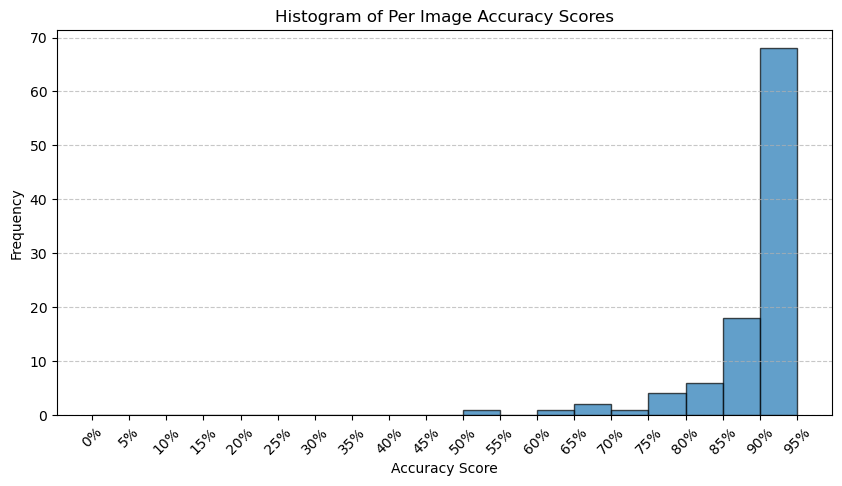

In [30]:
accuracies = [acc for _, acc in ranked_accuracies]
# Move accuracies to CPU and convert to a NumPy array
accuracies = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in accuracies]

# Define bins from 0.8 to 1 with interval of 0.02
bins = np.arange(0.0, 1.0, 0.05)

# Create histogram
plt.figure(figsize=(10, 5))
plt.hist(accuracies, bins=bins, edgecolor='black', alpha=0.7)

# Convert x-ticks to percentage
plt.xticks(bins, labels=[f"{int(b * 100)}%" for b in bins], rotation=45)

# Labels and title
plt.xlabel("Accuracy Score")
plt.ylabel("Frequency")
plt.title("Histogram of Per Image Accuracy Scores")
plt.xticks(bins, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

The histogram outputs the distribution of the individual image segmentation accurcary. While most of the dataset are distributed within the range of 60 - 100%, there are some outliers with individual image segmentation accuracy, unlike the baseline dataset.

### Evaluating individual image segmentation
This code extracts file names and their corresponding pixel-wise accuracies from the per_image_accuracy_dict dictionary outputted from the evaluation function. It then sorts these pairs by accuracy in descending order. Finally, it displays the top-ranked files along with their accuracy formatted as a percentage and ranks them.

#### Visual analysis of top and bottom 10 segmentation accuracies 
The following few codes will preprocess the predicted outputs collected from the evaluation and visualize the top and bottom images based on segmentation accuracy. It displays three columns for each of the top N images: the original image, the predicted mask, and the true mask. The masks are color-coded using a custom colormap defined by specific class colors (e.g., Noise, NR, LTE, Unknown). The function also includes a legend for the classes, and each image is annotated with its accuracy.

In [31]:
# Initialize lists for images, predictions, labels, and file names
images_list = []
all_segmentation_preds = [] 
all_segmentation_labels = []
file_names_list = []  # New list for storing file names
accuracies_list = []

# Iterate through the ranked_accuracies (which contains file_name and accuracy dict)
for file_name, accuracy_tensor in ranked_accuracies:
    # Retrieve the dictionary with image, prediction, and label using the file_name
    accuracy_info = per_image_accuracy_dict.get(file_name, None)
    
    if accuracy_info is not None:
        image = accuracy_info['image']  # Extract image from the dictionary
        segmentation_preds = accuracy_info['segmentation_pred']  # Extract predictions
        segmentation_labels = accuracy_info['segmentation_label']  # Extract labels
        accuracy = accuracy_info['accuracy']
        
        # Move tensor to CPU and convert it to a NumPy value
        accuracy = accuracy.cpu().numpy() if torch.is_tensor(accuracy) else accuracy
        
        images_list.append(image)  # Append image to list
        all_segmentation_preds.append(segmentation_preds)
        all_segmentation_labels.append(segmentation_labels)
        file_names_list.append(file_name)  # Append file name to the new list
        accuracies_list.append(accuracy)  # Append accuracy value to the list

# Flatten the images into a single array
flat_images_list = np.concatenate(images_list, axis=0)  # Shape: (184, C, H, W)

# Convert accuracies_list to a NumPy array (no need for .cpu() since it's already handled)
accuracies_list = np.array(accuracies_list)

# Now flat_images_list contains all the images in a flattened form, ready for visualization
# And file_names_list contains the corresponding file names
# accuracies_list is a NumPy array now


In [32]:
# Check the shape of images_list 
print(f"Shape of flat_images_list: {np.array(flat_images_list).shape}")

# Check the shape of all_segmentation_preds
print(f"Shape of all_segmentation_preds: {np.array(all_segmentation_preds).shape}")

# Check the shape of all_segmentation_labels
print(f"Shape of all_segmentation_labels: {np.array(all_segmentation_labels).shape}")

print(f"Shape of file_names_list: {np.array(file_names_list).shape}")
# Now you can check the shape
print(f"Shape of accuracy_list: {accuracies_list.shape}")

Shape of flat_images_list: (600, 128, 128)
Shape of all_segmentation_preds: (200, 128, 128)
Shape of all_segmentation_labels: (200, 128, 128)
Shape of file_names_list: (200,)
Shape of accuracy_list: (200,)


In [33]:
def visualize_top_images(images_list, all_segmentation_preds, all_segmentation_labels, file_names_list, class_names, accuracies_list, top_n=10):
    """
    Visualizes the top and bottom N images along with their predicted and true masks, including a color legend for classes.

    Args:
        images_list (numpy.ndarray): Array of original images (N, C, H, W) or (N, H, W) if grayscale.
        all_segmentation_preds (numpy.ndarray): Array of predicted masks (N, H, W).
        all_segmentation_labels (numpy.ndarray): Array of ground truth masks (N, H, W).
        file_names_list (list): List of file names corresponding to the images.
        class_names (list): List of class names (e.g., ['Noise', 'NR', 'LTE', 'Unknown']).
        accuracies_list (list): List of accuracies corresponding to each image.
        top_n (int): Number of top and bottom images to display.

    Returns:
        None (Displays images in a matplotlib figure).
    """
    # Define hardcoded class colors (RGBA format or any other color format you prefer)
    class_colors = [
        (0.0, 0.0, 0.5),  # Noise (Dark Blue)
        (0.678, 0.847, 0.902),  # NR (Light Blue)
        (1.0, 1.0, 0.0),  # LTE (Yellow)
        (0.647, 0.165, 0.165),  # Unknown (Brown)
    ]
    
    # Create a custom colormap and normalize based on class colors
    cmap = colors.ListedColormap(class_colors)
    norm = colors.BoundaryNorm(boundaries=np.arange(len(class_colors) + 1), ncolors=len(class_colors))

    # Set up figure size to avoid overlap
    fig, axes = plt.subplots(top_n, 3, figsize=(10, top_n * 3))

    print("Top segmentation accuracies:")
    for i in range(top_n):
        # Get the image, predicted mask, true mask, file name, and accuracy for the top N images
        image = images_list[i]
        pred_mask = all_segmentation_preds[i]
        true_mask = all_segmentation_labels[i]
        file_name = file_names_list[i]
        accuracy = accuracies_list[i]  # Get the accuracy for this image

        # If image is (C, H, W), transpose it to (H, W, C)
        if image.ndim == 3 and image.shape[0] == 3:  
            image = np.transpose(image, (1, 2, 0))

        # Display Original Image
        cmap_image = "gray" if image.ndim == 2 else None  # Grayscale images
        axes[i, 0].imshow(image, cmap=cmap_image)
        axes[i, 0].set_title(f"Image {file_name}\nAccuracy: {accuracy*100:.2f}%")  # Display the accuracy from accuracies_list
        axes[i, 0].axis("off")

        # Display Predicted Mask with hardcoded colors
        cax1 = axes[i, 1].imshow(pred_mask, cmap=cmap, norm=norm, alpha=0.7)
        axes[i, 1].set_title("Predicted Mask")
        axes[i, 1].axis("off")

        # Display True Mask with hardcoded colors
        cax2 = axes[i, 2].imshow(true_mask, cmap=cmap, norm=norm, alpha=0.7)
        axes[i, 2].set_title("True Mask")
        axes[i, 2].axis("off")

    # Adjust layout to add space for legend at the top
    plt.subplots_adjust(top=0.85)  # Add space at the top for the legend

    # Add horizontal legend at the top of the entire plot (outside the subplots)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i / len(class_colors)), markersize=10) for i in range(len(class_colors))]
    fig.legend(handles, class_names, loc="upper center", bbox_to_anchor=(0.6, 1.01), ncol=len(class_colors), title="Classes")

    plt.tight_layout()
    plt.show()


Top segmentation accuracies:


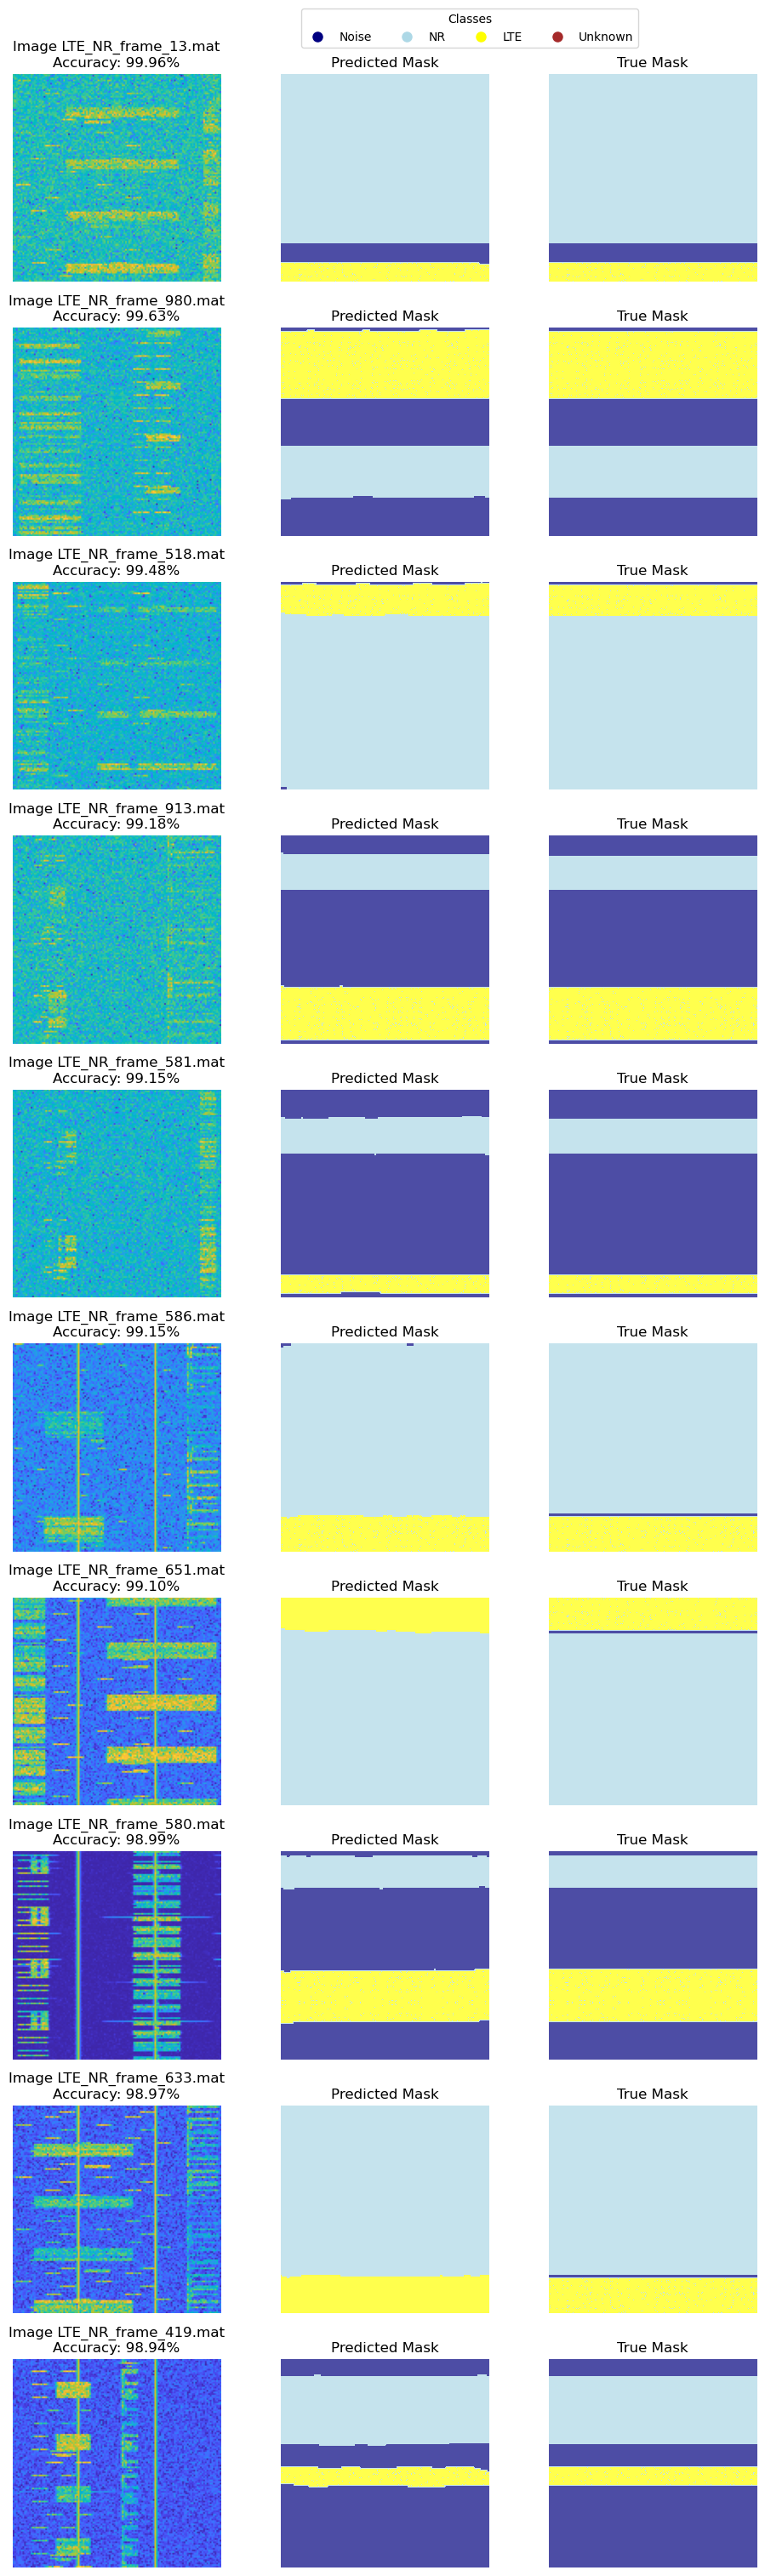

In [34]:
visualize_top_images(images_list, all_segmentation_preds, all_segmentation_labels, file_names_list, class_names, accuracies_list, top_n=10)


In [35]:
def visualize_bottom_images(flat_images_list, all_segmentation_preds, all_segmentation_labels, accuracies_list, class_names, top_n=10):
    """
    Visualizes the top and bottom N images along with their predicted and true masks, including a color legend for classes.

    Args:
        flat_images_list (numpy.ndarray): Array of original images (N, C, H, W) or (N, H, W) if grayscale.
        all_segmentation_preds (numpy.ndarray): Array of predicted masks (N, H, W).
        all_segmentation_labels (numpy.ndarray): Array of ground truth masks (N, H, W).
        accuracies_list (list): List of accuracies corresponding to each image.
        class_names (list): List of class names (e.g., ['Noise', 'NR', 'LTE', 'Unknown']).
        top_n (int): Number of top and bottom images to display.

    Returns:
        None (Displays images in a matplotlib figure).
    """
    # Sort the accuracies in ascending order to get the bottom N
    bottom_indices = np.argsort(accuracies_list)[:top_n]  # Indices of bottom N images

    # Define hardcoded class colors (RGBA format or any other color format you prefer)
    class_colors = [
    (0.0, 0.0, 0.5),  # Noise (Dark Blue)
    (0.678, 0.847, 0.902),  # NR (Light Blue)
    (1.0, 1.0, 0.0),  # LTE (Yellow)
    (0.647, 0.165, 0.165),  # Unknown (Brown)
]

    
    # Create a custom colormap and normalize based on class colors
    cmap = colors.ListedColormap(class_colors)
    norm = colors.BoundaryNorm(boundaries=np.arange(len(class_colors) + 1), ncolors=len(class_colors))

    # Set up figure size to avoid overlap
    fig, axes = plt.subplots(top_n, 3, figsize=(10, top_n * 3))

    print("Bottom segmentation accuracies:")
    for i, idx in enumerate(bottom_indices):
        image = flat_images_list[idx]
        pred_mask = all_segmentation_preds[idx]
        true_mask = all_segmentation_labels[idx]
        file_name = file_names_list[idx]
        accuracy = accuracies_list[idx]  # Get the accuracy for this image

        # If image is (C, H, W), transpose it to (H, W, C)
        if image.ndim == 3 and image.shape[0] == 3:  
            image = np.transpose(image, (1, 2, 0))

        # Display Original Image
        cmap_image = "gray" if image.ndim == 2 else None  # Grayscale images
        axes[i, 0].imshow(image, cmap=cmap_image)
        axes[i, 0].set_title(f"Image {file_name}\nAccuracy: {accuracy*100:.2f}%")  # Display accuracy from accuracies_list
        axes[i, 0].axis("off")

        # Display Predicted Mask with hardcoded colors
        cax1 = axes[i, 1].imshow(pred_mask, cmap=cmap, norm=norm, alpha=0.7)
        axes[i, 1].set_title("Predicted Mask")
        axes[i, 1].axis("off")

        # Display True Mask with hardcoded colors
        cax2 = axes[i, 2].imshow(true_mask, cmap=cmap, norm=norm, alpha=0.7)
        axes[i, 2].set_title("True Mask")
        axes[i, 2].axis("off")

    # Adjust layout to add space for legend at the top
    plt.subplots_adjust(top=0.85)  # Add space at the top for the legend

    # Add horizontal legend at the top of the entire plot (outside the subplots)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i / len(class_colors)), markersize=10) for i in range(len(class_colors))]
    fig.legend(handles, class_names, loc="upper center", bbox_to_anchor=(0.6, 1.01), ncol=len(class_colors), title="Classes")

    plt.tight_layout()
    plt.show()


Bottom segmentation accuracies:


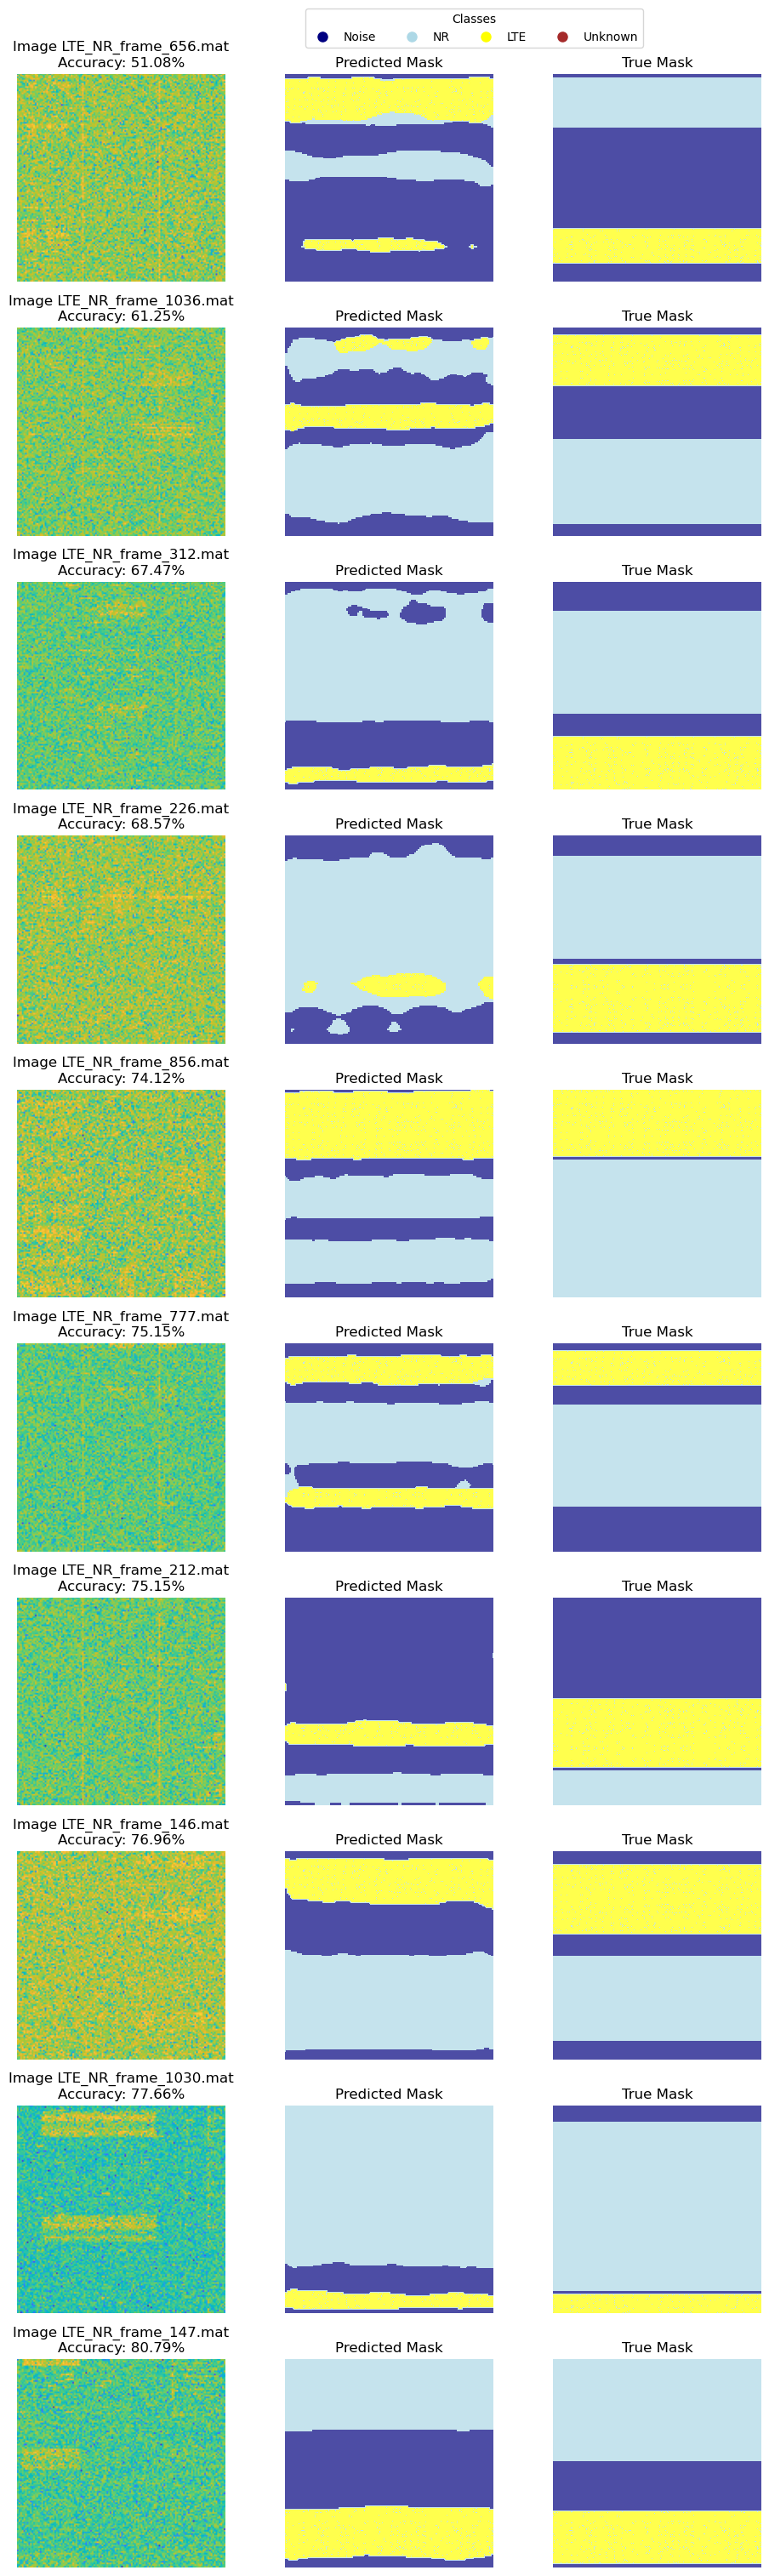

In [36]:
visualize_bottom_images(images_list, all_segmentation_preds, all_segmentation_labels, accuracies_list, class_names, top_n=10)


### Model interpritability

The following set of codes compare the per image accurcary against raw signal attributes for top and bottom 10 ranking accuracies to sense any sort of correlation. Following that, a heatmap was created for the entire dataset to establish any sorts of relationship with the signal attributes. 



#### Analysis of top 10 and top 10 segmentation accuracies:
The following codes compare the segmentation accuracies with the signal attributes to see a low-level features correlations.

In [37]:
# Bottom list - the last 10 files from file_names_list
bottom_list = file_names_list[-10:]

# Step 1: Create a dictionary for the ranked accuracies with file names as keys
ranked_accuracies_dict = {fname: accuracy.item() for fname, accuracy in ranked_accuracies}

# Step 2: Create a new dictionary that combines only the 'params_without_info' and the accuracy for files in the bottom_list
final_dict = {}

for data in processed_metadata_combined:
    file_name = data['file_name']
    
    if file_name in bottom_list and file_name in ranked_accuracies_dict:
        # Extract only 'params_without_info' and accuracy
        data_with_accuracy = {
            'params_without_info': data['params_without_info'],
            'accuracy': ranked_accuracies_dict[file_name]
        }
        
        # Add to final dictionary
        final_dict[file_name] = data_with_accuracy


In [38]:
# Step 1: Create an empty list to hold the rows for the DataFrame
data = []

# Step 2: Populate the list with dictionaries containing the file name, accuracy, and params_without_info
for file_name, info in final_dict.items():
    row = {
        'file_name': file_name,
        'accuracy': info['accuracy'],
        **info['params_without_info']  # Unpack the 'params_without_info' dictionary
    }
    data.append(row)

# Step 3: Convert the list of rows into a DataFrame
df = pd.DataFrame(data)


In [39]:
# Rank the DataFrame by accuracy in descending order
df_sorted = df.sort_values(by='accuracy', ascending=False)

# Multiply accuracy by 100 and rename column
df_sorted["accuracy"] = df_sorted["accuracy"] * 100
df_sorted.rename(columns={"accuracy": "Accuracy (%)"}, inplace=True)
df_sorted.style.set_table_styles([{"selector": "th, td", "props": [("border", "1px solid black")]}])

Upon analysis, there seems to a be a correlation to SNR value, most of which are negative value, which wasnt exposed to the inductive model.

In [40]:
import torch
import pprint

# Bottom list - the last 10 files from file_names_list
top_list = file_names_list[0:10]

# Step 1: Create a dictionary for the ranked accuracies with file names as keys
ranked_accuracies_dict = {fname: accuracy.item() for fname, accuracy in ranked_accuracies}

# Step 2: Create a new dictionary that combines only the 'params_without_info' and the accuracy for files in the bottom_list
final_dict = {}

for data in processed_metadata_combined:
    file_name = data['file_name']
    
    if file_name in top_list and file_name in ranked_accuracies_dict:
        # Extract only 'params_without_info' and accuracy
        data_with_accuracy = {
            'params_without_info': data['params_without_info'],
            'accuracy': ranked_accuracies_dict[file_name]
        }
        
        # Add to final dictionary
        final_dict[file_name] = data_with_accuracy



In [41]:
import pandas as pd

# Step 1: Create an empty list to hold the rows for the DataFrame
data = []

# Step 2: Populate the list with dictionaries containing the file name, accuracy, and params_without_info
for file_name, info in final_dict.items():
    row = {
        'file_name': file_name,
        'accuracy': info['accuracy'],
        **info['params_without_info']  # Unpack the 'params_without_info' dictionary
    }
    data.append(row)

# Step 3: Convert the list of rows into a DataFrame
df = pd.DataFrame(data)



In [42]:
# Rank the DataFrame by accuracy in descending order
df_sorted = df.sort_values(by='accuracy', ascending=False)

# Multiply accuracy by 100 and rename column
df_sorted["accuracy"] = df_sorted["accuracy"] * 100
df_sorted.rename(columns={"accuracy": "Accuracy (%)"}, inplace=True)

df_sorted.style.set_table_styles([{"selector": "th, td", "props": [("border", "1px solid black")]}])


There seems to be no correlation for any of the signal attributes

### Signal attributes feature correlation heatmap.
Despite analysing the top and bottom 10 accuracies, it is best to perform a correlation matrix for the entire test dataset so catch any missed correlations. The following sets of codes extract the respective signal attributes for the entire dataset and constructs a feature correlation heatmap.

In [43]:
files_list = file_names_list

# Step 1: Create a dictionary for the ranked accuracies with file names as keys
ranked_accuracies_dict = {fname: accuracy.item() for fname, accuracy in ranked_accuracies}

# Step 2: Create a new dictionary that combines only the 'params_without_info' and the accuracy for files in the files_list
final_dict = {}

for data in processed_metadata_combined:
    file_name = data['file_name']
    
    if file_name in files_list and file_name in ranked_accuracies_dict:
        # Extract only 'params_without_info' and accuracy
        data_with_accuracy = {
            'params_without_info': data['params_without_info'],
            'accuracy': ranked_accuracies_dict[file_name]
        }
        
        # Add to final dictionary
        final_dict[file_name] = data_with_accuracy

# Step 3: Pretty print the final dictionary
#pprint.pprint(final_dict)


In [44]:
# Step 1: Create an empty list to hold the rows for the DataFrame
data = []

# Step 2: Populate the list with dictionaries containing the file name, accuracy, and params_without_info
for file_name, info in final_dict.items():
    row = {
        'file_name': file_name,
        'accuracy': info['accuracy'],
        **info['params_without_info']  # Unpack the 'params_without_info' dictionary
    }
    data.append(row)

# Step 3: Convert the list of rows into a DataFrame
df = pd.DataFrame(data)

# Rank the DataFrame by accuracy in descending order
df_sorted = df.sort_values(by='accuracy', ascending=False)

# Print the sorted DataFrame
print(df_sorted)


                 file_name  accuracy  SCS  BW      SNRdB      Doppler  \
16     LTE_NR_frame_13.mat  0.999634   30   5  44.024166   253.700025   
199   LTE_NR_frame_980.mat  0.996338   30  20  26.369146   618.397312   
100   LTE_NR_frame_518.mat  0.994812   30  10  46.643932  1891.242455   
185   LTE_NR_frame_913.mat  0.991760   15  15  12.082218  1413.491378   
113   LTE_NR_frame_586.mat  0.991516   15  10  11.791463   685.029233   
..                     ...       ...  ...  ..        ...          ...   
172   LTE_NR_frame_856.mat  0.741211   15  20  -4.317286    37.010497   
44    LTE_NR_frame_226.mat  0.685730   15  20  -8.339570  1901.577322   
60    LTE_NR_frame_312.mat  0.674683   30  15  -6.402308  1759.726240   
7    LTE_NR_frame_1036.mat  0.612549   30  15  -9.191917  1145.726661   
130   LTE_NR_frame_656.mat  0.510803   30  10  -9.848698   680.890474   

     TrBlkOff  
16          3  
199         8  
100         4  
185         3  
113         6  
..        ...  
172        

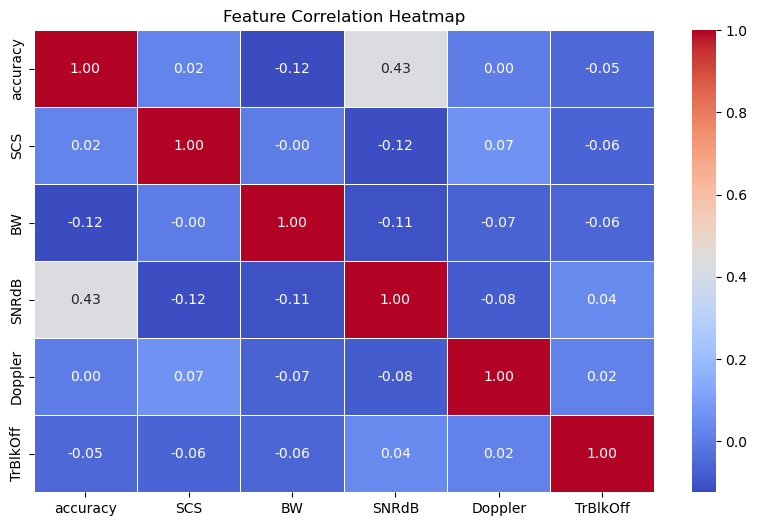

In [45]:
# Drop the 'file_name' column
df_numeric = df_sorted.drop(columns=["file_name"])

# Compute the correlation matrix
corr_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Title
plt.title("Feature Correlation Heatmap")
plt.show()


As evident from the heatmap, there seems to be a slight correlation with te SNR value and accurcary. This correlation, along with the analysis of the top and bottom 10 accuracy cases revealed that low-SNR samples (mostly negative values) had lower accuracy, while higher SNR samples showed no clear correlation. This suggests that the encoder, frozen during fine-tuning, may not have learned robust features for negative SNR values (only introduced in this dataset), leading to degraded performance in those cases. 

#### High-level feature extraction correlation
The following codes searches for a specific file name taken from the highest and lowest accuracy score, in the file_names list of the test_dataset.  
It then visualizes the selected file (higest and lowest accuracy) for a segmentation task using the SmoothGrad-CAM++ method to highlight the important regions in an image for each class. It first prepares a spectrogram input and computes the model's output probabilities using a pre-trained DeepLabv3+ model. The Grad-CAM method is applied to each class, creating heatmaps that are overlaid on the original spectrogram to show which regions the model focuses on for each class. The segmentation mask is also reconstructed and visualized with percentages of class coverage. Additionally, the plot includes a custom legend displaying the class names along with their coverage percentages, offering a detailed visual interpretation of model predictions and confidence levels.

In [46]:
# Find the index of the highest accuracy file name
highest_accuracy_index = None
for i, file_name in enumerate(test_dataset.file_names):
    if file_name == highest_accuracy_file:
        highest_accuracy_index = i
        break

# Find the index of the lowest accuracy file name
lowest_accuracy_index = None
for i, file_name in enumerate(test_dataset.file_names):
    if file_name == lowest_accuracy_file:
        lowest_accuracy_index = i
        break


# Check if the file names were found and print the indices
if highest_accuracy_index is not None:
    print(f"The index of the highest accuracy file ({highest_accuracy_file}) is {highest_accuracy_index}")
else:
    print(f"{highest_accuracy_file} not found in the dataset.")

if lowest_accuracy_index is not None:
    print(f"The index of the lowest accuracy file ({lowest_accuracy_file}) is {lowest_accuracy_index}")
else:
    print(f"{lowest_accuracy_file} not found in the dataset.")

The index of the highest accuracy file (LTE_NR_frame_13.mat) is 39
The index of the lowest accuracy file (LTE_NR_frame_656.mat) is 106


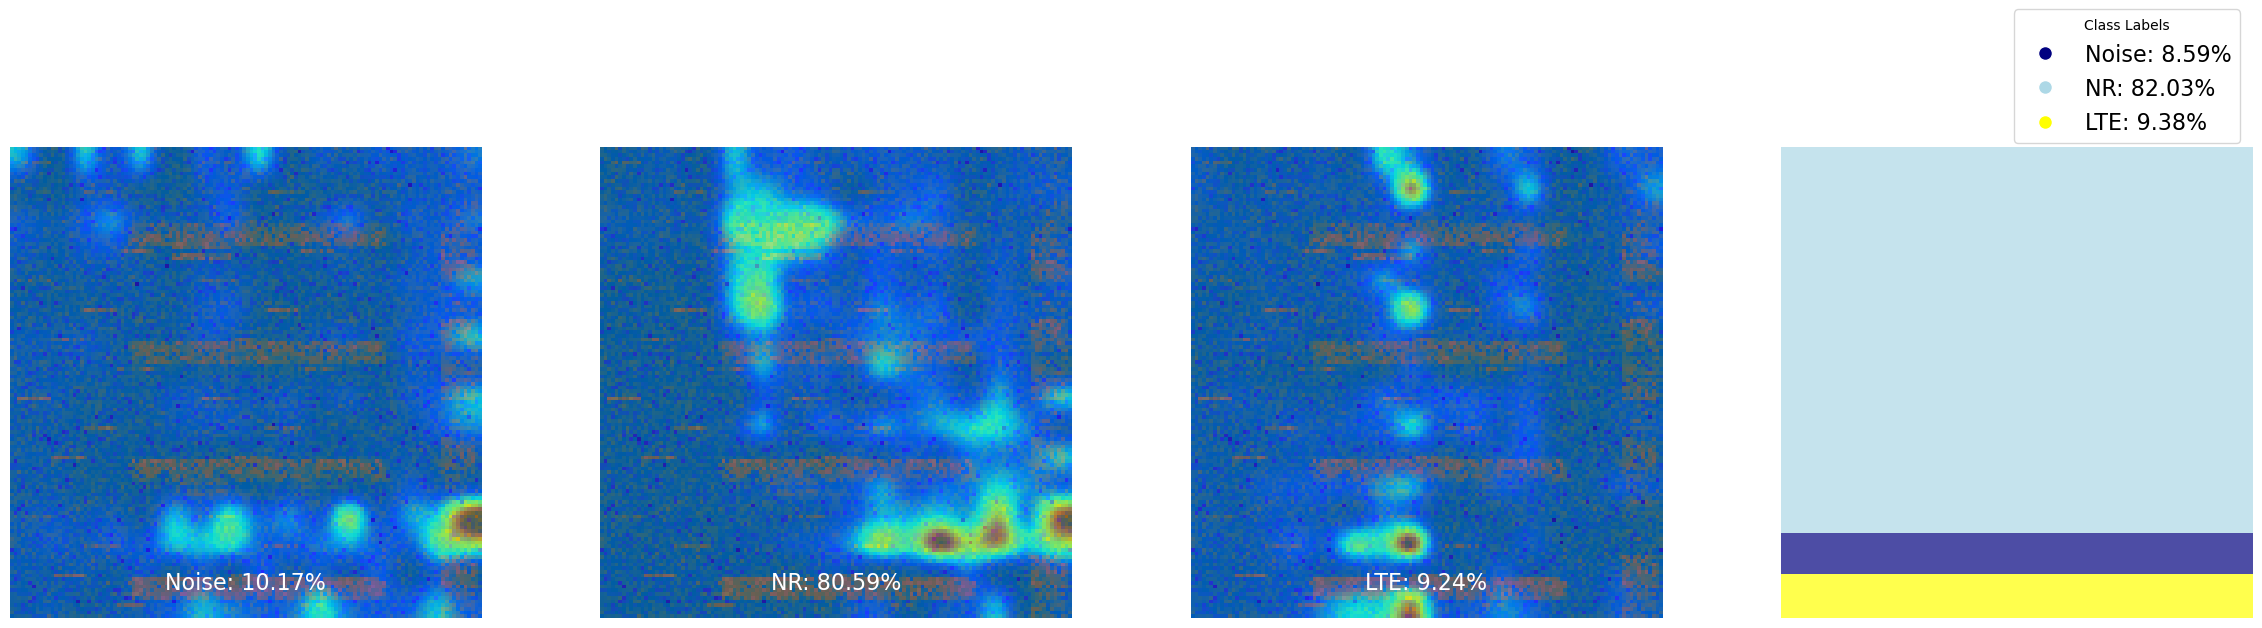

In [47]:
index = highest_accuracy_index

class_labels = ['Noise', 'NR', 'LTE']  # Example labels
num_classes = len(class_labels)

# Define hardcoded class colors (RGBA format or any other color format you prefer)
class_colors = [
    (0.0, 0.0, 0.5),  # Noise (Dark Blue)
    (0.678, 0.847, 0.902),  # NR (Light Blue)
    (1.0, 1.0, 0.0),  # LTE (Yellow)
]

# Create a custom colormap from the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)

# Reconstruct segmentation masks from ground truth labels 
def reconstruct_segmentation_mask(labels):
    segmentation_mask = torch.zeros(labels.shape, dtype=torch.long)
    for class_idx in range(num_classes):
        segmentation_mask[labels == class_idx] = class_idx
    return segmentation_mask

# Create a function to compute class percentage in the segmentation mask
def compute_class_percentage(segmentation_mask):
    percentages = {}
    for class_idx in range(num_classes):
        total_pixels = segmentation_mask.numel()
        class_pixels = (segmentation_mask == class_idx).sum().item()
        percentages[class_labels[class_idx]] = (class_pixels / total_pixels) * 100
    return percentages


deeplab_model.eval()

# Select the last convolutional layer (DeepLabv3+ in SMP uses 'encoder.layer4')
cam_extractor = SmoothGradCAMpp(deeplab_model, target_layer="encoder.layer4")


# Load a spectrogram input 
input_image = images_test_tensor[index].unsqueeze(0)  # Select one image (batch size 1)
input_label = labels_test_tensor[index]
# Move the input image to the device
input_image = input_image.to(device)
input_label = input_label.to(device)

# Set requires_grad to True to track gradients for Grad-CAM
input_image.requires_grad_()

# Get the model output
output = deeplab_model(input_image)

# Apply softmax to get probabilities
output_probs = F.softmax(output, dim=1)  # Apply softmax over the classes (dim=1)

# Reconstruct the segmentation mask
segmentation_mask = reconstruct_segmentation_mask(input_label)

# Compute class percentages for the segmentation mask
mask_percentages = compute_class_percentage(segmentation_mask)

# Create a single figure for all plots with larger size
fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # Increase figure size for better visibility

# Compute Grad-CAM for each class
for class_idx in range(output.size(1)):  # Loop over all the classes (output channels)
    # Compute Grad-CAM for the current class
    activation_map = cam_extractor(class_idx, output)
    
    # Overlay the heatmap on the spectrogram for the current class
    result = overlay_mask(to_pil_image(input_image.squeeze(0)), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
    
    # Plot the result for the current class on the respective subplot
    ax = axes[class_idx]
    ax.imshow(result)
    ax.axis("off")
    
    # Get the probability of the current class by averaging over spatial dimensions (height, width)
    confidence_score = output_probs[0, class_idx].mean().item()  # Use mean over height and width
    predicted_label = class_labels[class_idx]  # Get the label corresponding to the class index
    
    # Add the label and score to the image (title)
    ax.set_title(f"{predicted_label}: {confidence_score*100:.2f}%", fontsize=16, color="white")

    # If title still does not show, try adding text directly on the image
    ax.text(0.5, 0.05, f"{predicted_label}: {confidence_score*100:.2f}%", ha='center', va='bottom', fontsize=16, color="white", transform=ax.transAxes)

# After the mask plot
mask_fig = axes[3]
mask_fig.imshow(segmentation_mask.cpu().numpy(), cmap=cmap, alpha=0.7)
mask_fig.axis("off")

# Add percentages directly on the segmentation mask plot
for class_idx in range(num_classes):
    # Compute the percentage for the current class
    percentage = mask_percentages[class_labels[class_idx]]
    
    # Get the position for placing the text (you can adjust these values as needed)
    y_position = (class_idx + 0.5) * (1 / num_classes)  # Adjust this to control vertical positioning
    


# Create custom legend handles for the segmentation classes with percentages
legend_labels = [f"{class_labels[class_idx]}: {mask_percentages[class_labels[class_idx]]:.2f}%" 
                 for class_idx in range(num_classes)]
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) 
                  for c in class_colors]

# Add the legend to the plot with percentages in the labels
mask_fig.legend(legend_handles, legend_labels, title="Class Labels", loc="center left", bbox_to_anchor=(0.47, 1.15), fontsize=16)

# Adjust layout for better spacing and display
plt.tight_layout()
plt.show()


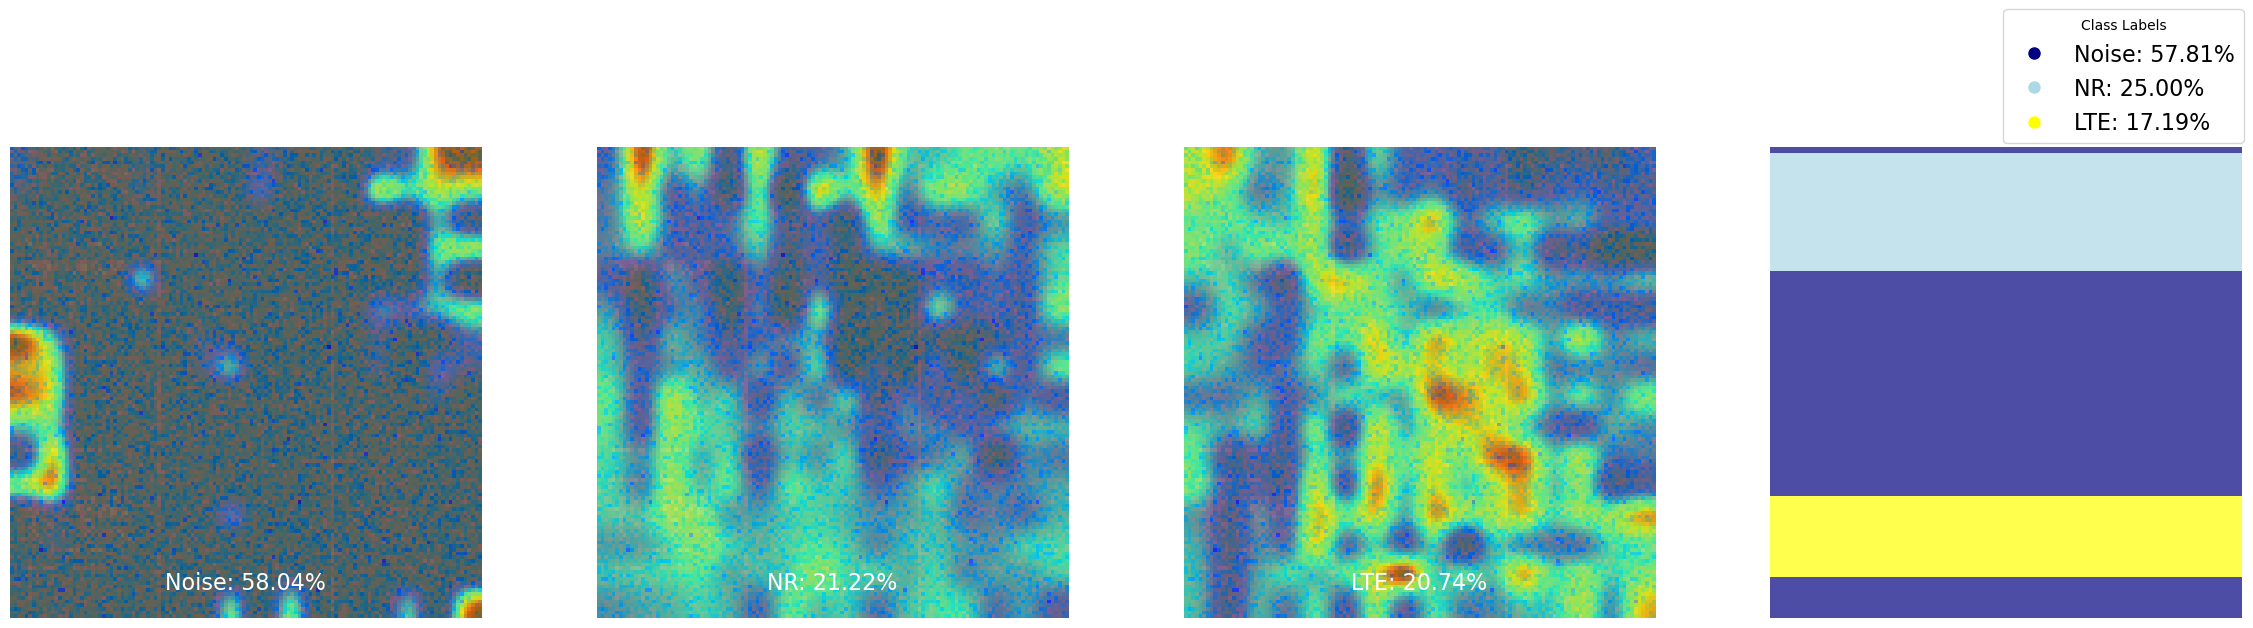

In [48]:
index = lowest_accuracy_index

class_labels = ['Noise', 'NR', 'LTE']  # Example labels
num_classes = len(class_labels)

# Define hardcoded class colors (RGBA format or any other color format you prefer)
class_colors = [
    (0.0, 0.0, 0.5),  # Noise (Dark Blue)
    (0.678, 0.847, 0.902),  # NR (Light Blue)
    (1.0, 1.0, 0.0),  # LTE (Yellow)
]

# Create a custom colormap from the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)

# Reconstruct segmentation masks from ground truth labels
def reconstruct_segmentation_mask(labels):
    segmentation_mask = torch.zeros(labels.shape, dtype=torch.long)
    for class_idx in range(num_classes):
        segmentation_mask[labels == class_idx] = class_idx
    return segmentation_mask

# Create a function to compute class percentage in the segmentation mask
def compute_class_percentage(segmentation_mask):
    percentages = {}
    for class_idx in range(num_classes):
        total_pixels = segmentation_mask.numel()
        class_pixels = (segmentation_mask == class_idx).sum().item()
        percentages[class_labels[class_idx]] = (class_pixels / total_pixels) * 100
    return percentages


deeplab_model.eval()

# Select the last convolutional layer (DeepLabv3+ in SMP uses 'encoder.layer4')
cam_extractor = SmoothGradCAMpp(deeplab_model, target_layer="encoder.layer4")


# Load a spectrogram input 
input_image = images_test_tensor[index].unsqueeze(0)  # Select one image (batch size 1)
input_label = labels_test_tensor[index]
# Move the input image to the device
input_image = input_image.to(device)
input_label = input_label.to(device)

# Set requires_grad to True to track gradients for Grad-CAM
input_image.requires_grad_()

# Get the model output
output = deeplab_model(input_image)

# Apply softmax to get probabilities
output_probs = F.softmax(output, dim=1)  # Apply softmax over the classes (dim=1)

# Reconstruct the segmentation mask
segmentation_mask = reconstruct_segmentation_mask(input_label)

# Compute class percentages for the segmentation mask
mask_percentages = compute_class_percentage(segmentation_mask)

# Create a single figure for all plots with larger size
fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # Increase figure size for better visibility

# Compute Grad-CAM for each class
for class_idx in range(output.size(1)):  # Loop over all the classes (output channels)
    # Compute Grad-CAM for the current class
    activation_map = cam_extractor(class_idx, output)
    
    # Overlay the heatmap on the spectrogram for the current class
    result = overlay_mask(to_pil_image(input_image.squeeze(0)), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
    
    # Plot the result for the current class on the respective subplot
    ax = axes[class_idx]
    ax.imshow(result)
    ax.axis("off")
    
    # Get the probability of the current class by averaging over spatial dimensions (height, width)
    confidence_score = output_probs[0, class_idx].mean().item()  # Use mean over height and width
    predicted_label = class_labels[class_idx]  # Get the label corresponding to the class index
    
    # Add the label and score to the image (title)
    ax.set_title(f"{predicted_label}: {confidence_score*100:.2f}%", fontsize=16, color="white")

    # If title still does not show, try adding text directly on the image
    ax.text(0.5, 0.05, f"{predicted_label}: {confidence_score*100:.2f}%", ha='center', va='bottom', fontsize=16, color="white", transform=ax.transAxes)

# After the mask plot
mask_fig = axes[3]
mask_fig.imshow(segmentation_mask.cpu().numpy(), cmap=cmap, alpha=0.7)
mask_fig.axis("off")

# Add percentages directly on the segmentation mask plot
for class_idx in range(num_classes):
    # Compute the percentage for the current class
    percentage = mask_percentages[class_labels[class_idx]]
    
    # Get the position for placing the text (you can adjust these values as needed)
    y_position = (class_idx + 0.5) * (1 / num_classes)  # Adjust this to control vertical positioning
    


# Create custom legend handles for the segmentation classes with percentages
legend_labels = [f"{class_labels[class_idx]}: {mask_percentages[class_labels[class_idx]]:.2f}%" 
                 for class_idx in range(num_classes)]
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) 
                  for c in class_colors]

# Add the legend to the plot with percentages in the labels
mask_fig.legend(legend_handles, legend_labels, title="Class Labels", loc="center left", bbox_to_anchor=(0.47, 1.15), fontsize=16)

# Adjust layout for better spacing and display
plt.tight_layout()
plt.show()


### Classification Analysis
The evaluate_segmentation_errors function analyzes the errors in segmentation predictions by calculating key metrics such as Intersection over Union (IoU) per class and generating a confusion matrix. First, it calculates the IoU for each class by comparing the predicted and true labels for each pixel, storing the results in a list. It then prints the IoU score for each class, providing insights into how well the model performs for each class. The function proceeds by calculating a confusion matrix, which shows how often each class is predicted as another class. The matrix is normalized by the sum of each row to express the values as percentages. The normalized confusion matrix is then visualized as a heatmap with labels and percentage values for easier interpretation. Finally, the function returns the IoU scores for each class. This helps in understanding specific weaknesses in the model's predictions, especially for certain classes.

In [49]:
def evaluate_segmentation_errors(all_segmentation_preds, all_segmentation_labels, class_names):
    """
    Perform error analysis on segmentation predictions.
    - Computes IoU per class.
    - Generates a confusion matrix.
    - Displays sample misclassifications.
    """

    num_classes = len(class_names)

    # Convert lists to NumPy arrays
    all_segmentation_labels = np.array(all_segmentation_labels)
    all_segmentation_preds = np.array(all_segmentation_preds)


    # Compute Intersection over Union (IoU) per class
    ious = []
    for i in range(num_classes):
        iou = jaccard_score((all_segmentation_labels == i).flatten(),
                            (all_segmentation_preds == i).flatten(), zero_division=1)
        ious.append(iou)

    print("\nPer-Class IoU Scores:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {ious[i]:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), labels=range(num_classes))

    # Normalize confusion matrix by row (sum of each row)
    cm_sum = cm.sum(axis=1)[:, np.newaxis]  # Sum of each row
    cm_normalized = cm.astype('float') / cm_sum
    cm_normalized = np.nan_to_num(cm_normalized * 100)  # Handle NaN values by converting them to 0%

    # Plot confusion matrix as a heatmap with percentage sign
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Segmentation Confusion Matrix (Percentage)")
    plt.show()

    return ious


In [50]:
def evaluate_segmentation_errors(all_segmentation_preds, all_segmentation_labels, class_names):
    """
    Perform error analysis on segmentation predictions.
    - Computes IoU per class.
    - Generates a confusion matrix.
    - Displays sample misclassifications.
    """

    num_classes = len(class_names)

    # Convert lists to NumPy arrays
    all_segmentation_labels = np.array(all_segmentation_labels)
    all_segmentation_preds = np.array(all_segmentation_preds)


    # Compute Intersection over Union (IoU) per class
    ious = []
    for i in range(num_classes):
        iou = jaccard_score((all_segmentation_labels == i).flatten(),
                            (all_segmentation_preds == i).flatten(), zero_division=1)
        ious.append(iou)

    print("\nPer-Class IoU Scores:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {ious[i]:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), labels=range(num_classes))

    # Normalize confusion matrix by row (sum of each row)
    cm_sum = cm.sum(axis=1)[:, np.newaxis]  # Sum of each row
    cm_normalized = cm.astype('float') / cm_sum
    cm_normalized = np.nan_to_num(cm_normalized * 100)  # Handle NaN values by converting them to 0%

    # Plot confusion matrix as a heatmap with percentage sign
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Segmentation Confusion Matrix (Percentage)")
    plt.show()

    return ious



Per-Class IoU Scores:
Noise: 0.8549
NR: 0.8813
LTE: 0.8919
Unknown: 1.0000


C:\Users\mathu\AppData\Local\Temp\ipykernel_5832\827769929.py:32: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm_sum


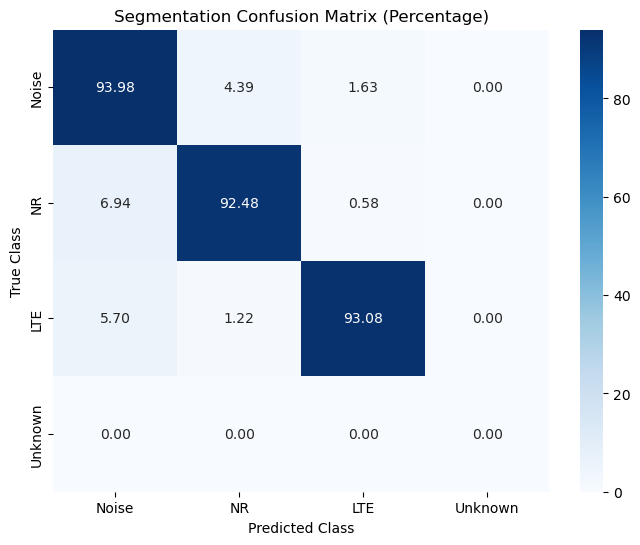

In [51]:
ious = evaluate_segmentation_errors(all_segmentation_preds, all_segmentation_labels, class_names)


IoU score:  measuring individual class performance. 
- Directly evaluates how well the predicted pixels align with the true pixels for each class.
- Useful when class imbalance exists (e.g., small object classes), as it measures overlap independently.
- Helps track improvement across training epochs in deep learning.

Confusion matrix: for understanding misclassification patterns
- Shows how different classes are confused with each other (e.g., if NR is often mistaken for LTE or Noise).
- Normalized confusion matrices make it easy to compare classes, even if they have different pixel counts.

Comparing to the inductive model, the classification accurcary per class, especially for NR and LTE has decreased comapared to the baseline dataset, providing futher proof that the inductive model, even after training the decoder, struggles to meet the classifcation performance of the baseline dataset.